In [8]:
import os
from Bio import SeqIO

In [9]:
def read_data():
    base_directory = './e_coli_paidb/'
    data = {}
    
    for name in os.listdir(base_directory):
        dir_path = os.path.join(base_directory, name)

        if os.path.isdir(dir_path):
            fasta_file = os.path.join(dir_path, f"{name}.fasta")
            pai_file   = os.path.join(dir_path, f"{name}.pai")
            cpai_file  = os.path.join(dir_path, f"{name}.cpai")
            npai_file  = os.path.join(dir_path, f"{name}.npai")

            data[name] = {}
            genome_sequence = next(SeqIO.parse(fasta_file, 'fasta'))
            data[name]['genome_sequence'] = genome_sequence

            with open(pai_file, 'r') as file:
                data[name]['pai_sequences'] = []

                while True:
                    line = file.readline()
                    if not line:
                        break

                    line = line.split()
                    pai_start_index = int(line[0])
                    pai_end_index = int(line[1])

                    pai_sequence = genome_sequence.seq[pai_start_index:pai_end_index]

                    data[name]['pai_sequences'].append((pai_sequence, (pai_start_index, pai_end_index)))

            with open(cpai_file, 'r') as file:
                data[name]['cpai_sequences'] = []

                while True:
                    line = file.readline()
                    if not line:
                        break

                    line = line.split()
                    cpai_start_index = int(line[0])
                    cpai_end_index = int(line[1])

                    cpai_sequence = genome_sequence.seq[cpai_start_index:cpai_end_index]

                    data[name]['cpai_sequences'].append((cpai_sequence, (cpai_start_index, cpai_end_index)))

            with open(npai_file, 'r') as file:
                data[name]['npai_sequences'] = []

                while True:
                    line = file.readline()
                    if not line:
                        break

                    line = line.split()
                    npai_start_index = int(line[0])
                    npai_end_index = int(line[1])

                    npai_sequence = genome_sequence.seq[npai_start_index:npai_end_index]

                    data[name]['npai_sequences'].append((npai_sequence, (npai_start_index, npai_end_index)))

    return data

### TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(sequence, k):
    kmers = get_kmers(str(sequence), k)
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform([kmers])
    tfidf_matrix = X.toarray()
    return tfidf_matrix, vectorizer

def get_kmers(sequence, k):
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    return ' '.join(kmers)

def get_kmers_map(tfidf_matrix, vectorizer, sequence, top_n=20):
    feature_names = vectorizer.get_feature_names_out()
    feature_scores = tfidf_matrix.flatten()
    
    top_kmers_indices = feature_scores.argsort()[-top_n:][::-1]
    top_kmers = [(feature_names[i], feature_scores[i]) for i in top_kmers_indices]

    mapped_kmers = {}
    for kmer, score in top_kmers:
        kmer = kmer.upper()
        count = sequence.count(kmer)
        mapped_kmers[kmer] = {'score': score, 'count': count}
        
    return mapped_kmers

def find_unique_kmers(full_sequence, start_index, end_index, significant_kmers, unique_kmers):
    for kmer, details in significant_kmers.items():
        left_occurrences = full_sequence[:start_index].count(kmer)
        right_occurrences = full_sequence[end_index:].count(kmer)
        occurrences = left_occurrences + right_occurrences
        if occurrences == 0:
            unique_kmers.append((kmer, details['count']))

In [4]:
def get_unique_patterns(full_sequence, island_sequence, start_index, end_index, k_max):
    
    unique_kmers = []
    
    for k in range(4, k_max):
        tfidf_matrix, vectorizer = tfidf(island_sequence, k)
        kmers = get_kmers_map(tfidf_matrix, vectorizer, island_sequence)
        find_unique_kmers(full_sequence, start_index, end_index, kmers, unique_kmers)
        
    return unique_kmers

#### Patterns unique for each island

In [39]:
e_coli_data = read_data()

In [5]:
import logging

logging.basicConfig(filename='tfidf.log', level=logging.INFO,
                    format='%(message)s')

console = logging.StreamHandler()
console.setLevel(logging.INFO)
console.setFormatter(logging.Formatter('%(message)s'))

logging.getLogger('').addHandler(console)

In [6]:
unique_pai_patterns  = {}
unique_cpai_patterns = {}
unique_npai_patterns = {}

k_max = 100
logging.info(f'Max pattern length: {k_max}')
logging.info('--------------------------')

for i, (name, data) in enumerate(e_coli_data.items()):
    logging.info(f'Genome {i+1}/{len(e_coli_data)}: {name}')
    
    if len(data['pai_sequences']) != 0:
        unique_pai_patterns[name] = {}
        genome_sequence = data['genome_sequence']
        for j, (pai_sequence, indices) in enumerate(data['pai_sequences']):
            unique_patterns = get_unique_patterns(genome_sequence, pai_sequence, indices[0], indices[1], k_max)

            unique_pai_patterns[name]['pai_sequence'] = pai_sequence
            unique_pai_patterns[name]['indices'] = indices
            unique_pai_patterns[name]['patterns'] = unique_patterns

            logging.info(f"PAI {j+1}/{len(data['pai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'e_coli_paidb/{name}/patterns/pai/', exist_ok=True)
            
            with open(f'e_coli_paidb/{name}/patterns/pai/pai_{j}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
                        
    else:
        logging.info('No PAI sequences')
    
    if len(data['cpai_sequences']) != 0:    
        unique_cpai_patterns[name] = {}

        genome_sequence = data['genome_sequence']
        for j, (cpai_sequence, indices) in enumerate(data['cpai_sequences']):
            unique_patterns = get_unique_patterns(genome_sequence, cpai_sequence, indices[0], indices[1], k_max)

            unique_cpai_patterns[name]['cpai_sequence'] = cpai_sequence
            unique_cpai_patterns[name]['indices'] = indices
            unique_cpai_patterns[name]['patterns'] = unique_patterns
            
            logging.info(f"CPAI {j+1}/{len(data['cpai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'e_coli_paidb/{name}/patterns/cpai/', exist_ok=True)
            
            with open(f'e_coli_paidb/{name}/patterns/cpai/cpai_{j}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
            
    else:
        logging.info('No CPAI sequences')
        
    if len(data['npai_sequences']) != 0:
        unique_npai_patterns[name] = {}
        genome_sequence = data['genome_sequence']
        for j, (npai_sequence, indices) in enumerate(data['npai_sequences']):
            unique_patterns = get_unique_patterns(genome_sequence, npai_sequence, indices[0], indices[1], k_max)

            unique_npai_patterns[name]['npai_sequence'] = npai_sequence
            unique_npai_patterns[name]['indices'] = indices
            unique_npai_patterns[name]['patterns'] = unique_patterns

            logging.info(f"NPAI {j+1}/{len(data['npai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'e_coli_paidb/{name}/patterns/npai/', exist_ok=True)
            
            with open(f'e_coli_paidb/{name}/patterns/npai/npai_{j}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
    
    else:
        logging.info('No NPAI sequences')
    logging.info('--------------------------')

Max pattern length: 100
--------------------------
Genome 1/90: NC_010468
No PAI sequences
CPAI 1/3: 1742 unique patterns
CPAI 2/3: 1735 unique patterns
CPAI 3/3: 631 unique patterns
NPAI 1/2: 1743 unique patterns
NPAI 2/2: 1746 unique patterns
--------------------------
Genome 2/90: NC_011748
No PAI sequences
CPAI 1/10: 641 unique patterns
CPAI 2/10: 1760 unique patterns
CPAI 3/10: 1751 unique patterns
CPAI 4/10: 1749 unique patterns
CPAI 5/10: 1619 unique patterns
CPAI 6/10: 581 unique patterns
CPAI 7/10: 36 unique patterns
CPAI 8/10: 1638 unique patterns
CPAI 9/10: 1648 unique patterns
CPAI 10/10: 1066 unique patterns
NPAI 1/1: 1740 unique patterns
--------------------------
Genome 3/90: NC_011751
PAI 1/1: 1454 unique patterns
CPAI 1/7: 657 unique patterns
CPAI 2/7: 1754 unique patterns
CPAI 3/7: 1738 unique patterns
CPAI 4/7: 1745 unique patterns
CPAI 5/7: 1753 unique patterns
CPAI 6/7: 1748 unique patterns
CPAI 7/7: 1399 unique patterns
NPAI 1/2: 1748 unique patterns
NPAI 2/2: 173

CPAI 3/8: 1752 unique patterns
CPAI 4/8: 1749 unique patterns
CPAI 5/8: 1744 unique patterns
CPAI 6/8: 1736 unique patterns
CPAI 7/8: 1743 unique patterns
CPAI 8/8: 1746 unique patterns
NPAI 1/3: 1749 unique patterns
NPAI 2/3: 1749 unique patterns
NPAI 3/3: 1750 unique patterns
--------------------------
Genome 34/90: NC_009800
No PAI sequences
CPAI 1/4: 654 unique patterns
CPAI 2/4: 1768 unique patterns
CPAI 3/4: 1407 unique patterns
CPAI 4/4: 1736 unique patterns
NPAI 1/1: 1688 unique patterns
--------------------------
Genome 35/90: NC_004431
PAI 1/2: 14 unique patterns
PAI 2/2: 4 unique patterns
CPAI 1/12: 664 unique patterns
CPAI 2/12: 1716 unique patterns
CPAI 3/12: 1744 unique patterns
CPAI 4/12: 1753 unique patterns
CPAI 5/12: 10 unique patterns
CPAI 6/12: 1742 unique patterns
CPAI 7/12: 1678 unique patterns
CPAI 8/12: 1626 unique patterns
CPAI 9/12: 1753 unique patterns
CPAI 10/12: 1748 unique patterns
CPAI 11/12: 1633 unique patterns
CPAI 12/12: 6 unique patterns
NPAI 1/2: 17

--------------------------
Genome 66/90: NC_012947
No PAI sequences
CPAI 1/5: 1756 unique patterns
CPAI 2/5: 1767 unique patterns
CPAI 3/5: 1742 unique patterns
CPAI 4/5: 1743 unique patterns
CPAI 5/5: 1753 unique patterns
NPAI 1/2: 0 unique patterns
NPAI 2/2: 1684 unique patterns
--------------------------
Genome 67/90: NC_011747
No PAI sequences
CPAI 1/3: 1803 unique patterns
CPAI 2/3: 1759 unique patterns
CPAI 3/3: 1803 unique patterns
NPAI 1/1: 1813 unique patterns
--------------------------
Genome 68/90: NC_013654
No PAI sequences
CPAI 1/4: 1746 unique patterns
CPAI 2/4: 1413 unique patterns
CPAI 3/4: 1737 unique patterns
CPAI 4/4: 1394 unique patterns
NPAI 1/2: 1745 unique patterns
NPAI 2/2: 1743 unique patterns
--------------------------
Genome 69/90: NC_011745
No PAI sequences
CPAI 1/11: 659 unique patterns
CPAI 2/11: 1561 unique patterns
CPAI 3/11: 1739 unique patterns
CPAI 4/11: 1528 unique patterns
CPAI 5/11: 1410 unique patterns
CPAI 6/11: 1751 unique patterns
CPAI 7/11: 13

In [23]:
import json

with open('pai_patterns.json', 'w') as file:
    json.dump(unique_pai_patterns, file)
    
with open('cpai_patterns.json', 'w') as file:
    json.dump(unique_cpai_patterns, file)
    
with open('npai_patterns.json', 'w') as file:
    json.dump(unique_npai_patterns, file)

#### Unique patterns that appear in multiple islands

In [4]:
e_coli_data = read_data()

In [5]:
import logging

logging.basicConfig(filename='logs/tfidf_all_islands.log', level=logging.INFO,
                    format='%(message)s')

console = logging.StreamHandler()
console.setLevel(logging.INFO)
console.setFormatter(logging.Formatter('%(message)s'))

logging.getLogger('').addHandler(console)

In [1]:
from Bio import Align
from Bio.Seq import Seq

In [2]:
def count_matches(sequence, pattern):
    aligner = Align.PairwiseAligner()
    aligner.mode = 'local'
    aligner.match_score = 2
    aligner.mismatch_score = -2
    aligner.open_gap_score = -2
    aligner.extend_gap_score = -1
    
    alignments = aligner.align(sequence, pattern)
    threshold = 0.85 * (2 * len(pattern))
    
    return sum(1 for alignment in alignments if alignment.score >= threshold)

In [8]:
def find_islands_kmers(full_sequence,
                       pai_islands,
                       cpai_islands,
                       npai_islands,
                       significant_kmers,
                       all_islands_kmers):
    
    all_islands = pai_islands + cpai_islands + npai_islands
    all_islands.sort(key=lambda x: x[0])
        
    for kmer, details in significant_kmers.items():
        
        if kmer in all_islands_kmers:
            continue
        
        start = 0
        end = 0
        isUnique = True
        
        # Check if kmer doesn't exist outside of the islands
        for island in all_islands:
            end = island[0]
            
            if end > start:
                if count_matches(full_sequence[start:end], kmer) > 0:
                    isUnique = False
                    break
                    
            start = island[1]
                    
        if not isUnique or count_matches(full_sequence[start:], kmer) > 0:
            continue
          
        
        # Check which islands contain kmer
        islands_containing_kmer = []
        
        for num, pai_island in enumerate(pai_islands, start=1):
            start = pai_island[0]
            end = pai_island[1]
            
            count = count_matches(full_sequence[start:end], kmer)
            
            if count > 0:
                islands_containing_kmer.append(f'PAI {num}: {count}')
            
        for num, cpai_island in enumerate(cpai_islands, start=1):
            start = cpai_island[0]
            end = cpai_island[1]
            
            count = count_matches(full_sequence[start:end], kmer)
            
            if count > 0:
                islands_containing_kmer.append(f'CPAI {num}: {count}')
                
        for num, npai_island in enumerate(npai_islands, start=1):
            start = npai_island[0]
            end = npai_island[1]
            
            count = count_matches(full_sequence[start:end], kmer)
            
            if count > 0:
                islands_containing_kmer.append(f'NPAI {num}: {count}')
        
        all_islands_kmers[kmer] = islands_containing_kmer

In [9]:
def get_islands_kmers(full_sequence,
                      island_sequence,
                      pai_islands,
                      cpai_islands,
                      npai_islands,
                      all_islands_kmers,
                      k_max):
    
    
    for k in range(4, k_max):
        tfidf_matrix, vectorizer = tfidf(island_sequence, k)
        kmers = get_kmers_map(tfidf_matrix, vectorizer, island_sequence)
        find_islands_kmers(full_sequence, pai_islands, cpai_islands, npai_islands, kmers, all_islands_kmers)

In [10]:
k_max = 100
logging.info(f'Max pattern length: {k_max}')
logging.info('--------------------------')

unique_patterns = {}

for i, (name, data) in enumerate(e_coli_data.items()):
    logging.info(f'Genome {i+1}/{len(e_coli_data)}: {name}')
    
    genome_sequence = data['genome_sequence']
    all_islands_kmers = {}

    pai_indices = [x[1] for x in data['pai_sequences']]
    cpai_indices = [x[1] for x in data['cpai_sequences']]
    npai_indices = [x[1] for x in data['npai_sequences']]
    
    if len(data['pai_sequences']) != 0:
        
        for j, (pai_sequence, indices) in enumerate(data['pai_sequences']):
            
            len_before = len(all_islands_kmers)
            
            get_islands_kmers(genome_sequence,
                              pai_sequence,
                              pai_indices,
                              cpai_indices,
                              npai_indices,
                              all_islands_kmers,
                              k_max)
            
            new_patterns_found = len(all_islands_kmers) - len_before
            logging.info(f"PAI {j+1}/{len(data['pai_sequences'])}: {new_patterns_found} patterns found")
                        
    else:
        logging.info('No PAI sequences')
    
    
    if len(data['cpai_sequences']) != 0:
        
        for j, (cpai_sequence, indices) in enumerate(data['cpai_sequences']):
            
            len_before = len(all_islands_kmers)
            
            get_islands_kmers(genome_sequence,
                              cpai_sequence,
                              pai_indices,
                              cpai_indices,
                              npai_indices,
                              all_islands_kmers,
                              k_max)
            
            new_patterns_found = len(all_islands_kmers) - len_before
            logging.info(f"CPAI {j+1}/{len(data['cpai_sequences'])}: {new_patterns_found} patterns found")
            
    else:
        logging.info('No CPAI sequences')
        
        
    if len(data['npai_sequences']) != 0:

        for j, (npai_sequence, indices) in enumerate(data['npai_sequences']):
            
            len_before = len(all_islands_kmers)
            
            get_islands_kmers(genome_sequence,
                              npai_sequence,
                              pai_indices,
                              cpai_indices,
                              npai_indices,
                              all_islands_kmers,
                              k_max)
            
            new_patterns_found = len(all_islands_kmers) - len_before
            logging.info(f"NPAI {j+1}/{len(data['npai_sequences'])}: {new_patterns_found} patterns found")
    else:
        logging.info('No NPAI sequences')
    logging.info('--------------------------')
    
    unique_patterns[name] = all_islands_kmers
    os.makedirs(f'e_coli_paidb/{name}/patterns/all_islands/', exist_ok=True)
    
    with open(f'e_coli_paidb/{name}/patterns/all_islands/tfidf.txt', 'w') as file:
        for kmer in all_islands_kmers:
            file.write(kmer)
            file.write('\n')
            
            for island in all_islands_kmers[kmer]:
                file.write(island)
                file.write('\n')
            
            file.write('----------------\n')

Max pattern length: 100
--------------------------
Genome 1/90: NC_013365
No PAI sequences
CPAI 1/1: 1801 patterns found
No NPAI sequences
--------------------------
Genome 2/90: NC_020163
No PAI sequences
CPAI 1/2: 1649 patterns found
CPAI 2/2: 1726 patterns found
NPAI 1/1: 1736 patterns found
--------------------------
Genome 3/90: NC_017635
No PAI sequences
CPAI 1/4: 863 patterns found
CPAI 2/4: 1749 patterns found
CPAI 3/4: 1610 patterns found
CPAI 4/4: 1742 patterns found
NPAI 1/2: 1742 patterns found
NPAI 2/2: 1739 patterns found
--------------------------
Genome 4/90: NC_012971
No PAI sequences
CPAI 1/7: 1742 patterns found
CPAI 2/7: 1766 patterns found
CPAI 3/7: 1750 patterns found
CPAI 4/7: 1742 patterns found
CPAI 5/7: 1757 patterns found
CPAI 6/7: 1488 patterns found
CPAI 7/7: 1753 patterns found
NPAI 1/1: 1688 patterns found
--------------------------
Genome 5/90: NC_017625
No PAI sequences
CPAI 1/3: 996 patterns found
CPAI 2/3: 1744 patterns found
CPAI 3/3: 1751 patterns f

CPAI 10/10: 1751 patterns found
NPAI 1/2: 1750 patterns found
NPAI 2/2: 1748 patterns found
--------------------------
Genome 29/90: NC_011750
No PAI sequences
CPAI 1/9: 1361 patterns found
CPAI 2/9: 1754 patterns found
CPAI 3/9: 1450 patterns found
CPAI 4/9: 1717 patterns found
CPAI 5/9: 1680 patterns found
CPAI 6/9: 1686 patterns found
CPAI 7/9: 1750 patterns found
CPAI 8/9: 906 patterns found
CPAI 9/9: 0 patterns found
NPAI 1/2: 1638 patterns found
NPAI 2/2: 1741 patterns found
--------------------------
Genome 30/90: NC_012967
No PAI sequences
CPAI 1/7: 1741 patterns found
CPAI 2/7: 1765 patterns found
CPAI 3/7: 1683 patterns found
CPAI 4/7: 1742 patterns found
CPAI 5/7: 1756 patterns found
CPAI 6/7: 1487 patterns found
CPAI 7/7: 1753 patterns found
NPAI 1/1: 1687 patterns found
--------------------------
Genome 31/90: NC_012947
No PAI sequences
CPAI 1/5: 1756 patterns found
CPAI 2/5: 1767 patterns found
CPAI 3/5: 1742 patterns found
CPAI 4/5: 1744 patterns found
CPAI 5/5: 1753 pat

NPAI 2/2: 1747 patterns found
--------------------------
Genome 66/90: NC_013941
No PAI sequences
CPAI 1/5: 704 patterns found
CPAI 2/5: 1757 patterns found
CPAI 3/5: 1749 patterns found
CPAI 4/5: 1714 patterns found
CPAI 5/5: 1750 patterns found
NPAI 1/2: 1751 patterns found
NPAI 2/2: 1741 patterns found
--------------------------
Genome 67/90: NC_017633
No PAI sequences
CPAI 1/7: 656 patterns found
CPAI 2/7: 1699 patterns found
CPAI 3/7: 1753 patterns found
CPAI 4/7: 1517 patterns found
CPAI 5/7: 1608 patterns found
CPAI 6/7: 1751 patterns found
CPAI 7/7: 1659 patterns found
NPAI 1/2: 1691 patterns found
NPAI 2/2: 1747 patterns found
--------------------------
Genome 68/90: NC_013361
PAI 1/1: 1744 patterns found
CPAI 1/6: 1070 patterns found
CPAI 2/6: 1749 patterns found
CPAI 3/6: 1748 patterns found
CPAI 4/6: 1714 patterns found
CPAI 5/6: 1543 patterns found
CPAI 6/6: 1334 patterns found
NPAI 1/1: 1713 patterns found
--------------------------
Genome 69/90: NC_017637
No PAI sequence

In [13]:
with open('all_islands.json', 'w') as file:
    json.dump(unique_patterns, file)

#### Patterns that partially belong in the islands

In [5]:
e_coli_data = read_data()

In [6]:
import logging

logging.basicConfig(filename='logs/tfidf_partial.log', level=logging.INFO,
                    format='%(message)s')

console = logging.StreamHandler()
console.setLevel(logging.INFO)
console.setFormatter(logging.Formatter('%(message)s'))

logging.getLogger('').addHandler(console)

In [14]:
def find_unique_kmers_partial(full_sequence, island_start_index, island_end_index, significant_kmers, unique_kmers):
    for kmer, details in significant_kmers.items():
        
        is_unique = True
        is_partial = False
        index = 0
        
        while index != -1:
            index = full_sequence.seq.find(kmer, index)
            if index != -1:
                start = index
                end = index + len(kmer)
                
                if start < island_start_index:
                    if end < island_start_index:
                        is_unique = False
                        break
                    else:
                        is_partial = True
                        
                if end > island_end_index:
                    if start > island_end_index:
                        is_unique = False
                        break
                    else:
                        is_partial = True
                
                index += len(kmer)
                
        if not is_unique or not is_partial:
            continue
        
        left_occurrences = full_sequence[:island_start_index].count(kmer)
        right_occurrences = full_sequence[island_end_index:].count(kmer)
        occurrences = left_occurrences + right_occurrences
        
        if occurrences == 0:
            unique_kmers.append((kmer, details['count']))
        else:
            print('Something went wrong')
            
def get_unique_patterns_partial(full_sequence, 
                                island_start_index,
                                island_end_index,
                                k_max):
    
    unique_kmers = []
    
    for k in range(4, k_max):
        
        start = island_start_index-k+1
        end = island_end_index+k-1
        
        if start < 0:
            start = 0
            
        if end > len(full_sequence.seq) - 1:
            end = len(full_sequence.seq) - 1
        
        island_sequence = full_sequence.seq[start:end]
        
        tfidf_matrix, vectorizer = tfidf(island_sequence, k)
        kmers = get_kmers_map(tfidf_matrix, vectorizer, island_sequence)
        find_unique_kmers_partial(full_sequence, island_start_index, island_end_index, kmers, unique_kmers)
        
    return unique_kmers

In [15]:
unique_pai_patterns  = {}
unique_cpai_patterns = {}
unique_npai_patterns = {}

k_max = 50
logging.info(f'Max pattern length: {k_max}')
logging.info('--------------------------')

for i, (name, data) in enumerate(e_coli_data.items()):
    if i < 47:
        continue
        
    logging.info(f'Genome {i+1}/{len(e_coli_data)}: {name}')
    
    if len(data['pai_sequences']) != 0:
        unique_pai_patterns[name] = {}
        genome_sequence = data['genome_sequence']
        for j, (pai_sequence, indices) in enumerate(data['pai_sequences']):
            unique_patterns = get_unique_patterns_partial(genome_sequence, indices[0], indices[1], k_max)

            unique_pai_patterns[name][f'pai_sequence_{j+1}'] = pai_sequence
            unique_pai_patterns[name][f'indices_pai_{j+1}'] = indices
            unique_pai_patterns[name][f'patterns_pai_{j+1}'] = unique_patterns

            logging.info(f"PAI {j+1}/{len(data['pai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'e_coli_paidb/{name}/patterns/tfidf/partial/pai/', exist_ok=True)
            
            with open(f'e_coli_paidb/{name}/patterns/tfidf/partial/pai/pai_{j+1}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
                        
    else:
        logging.info('No PAI sequences')
    
    if len(data['cpai_sequences']) != 0:    
        unique_cpai_patterns[name] = {}

        genome_sequence = data['genome_sequence']
        for j, (cpai_sequence, indices) in enumerate(data['cpai_sequences']):
            unique_patterns = get_unique_patterns_partial(genome_sequence, indices[0], indices[1], k_max)

            unique_cpai_patterns[name][f'cpai_sequence_{j+1}'] = cpai_sequence
            unique_cpai_patterns[name][f'indices_cpai_{j+1}'] = indices
            unique_cpai_patterns[name][f'patterns_cpai_{j+1}'] = unique_patterns
            
            logging.info(f"CPAI {j+1}/{len(data['cpai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'e_coli_paidb/{name}/patterns/tfidf/partial/cpai/', exist_ok=True)
            
            with open(f'e_coli_paidb/{name}/patterns/tfidf/partial/cpai/cpai_{j+1}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
            
    else:
        logging.info('No CPAI sequences')
        
    if len(data['npai_sequences']) != 0:
        unique_npai_patterns[name] = {}
        genome_sequence = data['genome_sequence']
        for j, (npai_sequence, indices) in enumerate(data['npai_sequences']):
            unique_patterns = get_unique_patterns_partial(genome_sequence, indices[0], indices[1], k_max)

            unique_npai_patterns[name][f'npai_sequence_{j+1}'] = npai_sequence
            unique_npai_patterns[name][f'indices_npai_{j+1}'] = indices
            unique_npai_patterns[name][f'patterns_npai_{j+1}'] = unique_patterns

            logging.info(f"NPAI {j+1}/{len(data['npai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'e_coli_paidb/{name}/patterns/tfidf/partial/npai/', exist_ok=True)
            
            with open(f'e_coli_paidb/{name}/patterns/tfidf/partial/npai/npai_{j+1}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
    
    else:
        logging.info('No NPAI sequences')
    logging.info('--------------------------')

Max pattern length: 50
--------------------------
Genome 48/90: NC_013366
No PAI sequences
No CPAI sequences
NPAI 1/2: 0 unique patterns
NPAI 2/2: 1 unique patterns
--------------------------
Genome 49/90: NC_011749
No PAI sequences
CPAI 1/1: 15 unique patterns
NPAI 1/1: 0 unique patterns
--------------------------
Genome 50/90: NC_017642
No PAI sequences
CPAI 1/1: 0 unique patterns
No NPAI sequences
--------------------------
Genome 51/90: NC_008253
No PAI sequences
CPAI 1/7: 0 unique patterns
CPAI 2/7: 0 unique patterns
CPAI 3/7: 0 unique patterns
CPAI 4/7: 9 unique patterns
CPAI 5/7: 0 unique patterns
CPAI 6/7: 0 unique patterns
CPAI 7/7: 0 unique patterns
NPAI 1/3: 0 unique patterns
NPAI 2/3: 0 unique patterns
NPAI 3/3: 0 unique patterns
--------------------------
Genome 52/90: NC_018654
No PAI sequences
No CPAI sequences
NPAI 1/1: 0 unique patterns
--------------------------
Genome 53/90: NC_018661
No PAI sequences
CPAI 1/13: 0 unique patterns
CPAI 2/13: 0 unique patterns
CPAI 3/1

CPAI 10/12: 0 unique patterns
CPAI 11/12: 0 unique patterns
CPAI 12/12: 0 unique patterns
NPAI 1/2: 0 unique patterns
NPAI 2/2: 0 unique patterns
--------------------------
Genome 83/90: NC_017637
No PAI sequences
No CPAI sequences
NPAI 1/1: 0 unique patterns
--------------------------
Genome 84/90: NC_017626
No PAI sequences
CPAI 1/11: 0 unique patterns
CPAI 2/11: 0 unique patterns
CPAI 3/11: 0 unique patterns
CPAI 4/11: 0 unique patterns
CPAI 5/11: 0 unique patterns
CPAI 6/11: 0 unique patterns
CPAI 7/11: 0 unique patterns
CPAI 8/11: 19 unique patterns
CPAI 9/11: 0 unique patterns
CPAI 10/11: 0 unique patterns
CPAI 11/11: 0 unique patterns
NPAI 1/1: 0 unique patterns
--------------------------
Genome 85/90: NC_022370
No PAI sequences
CPAI 1/8: 0 unique patterns
CPAI 2/8: 13 unique patterns
CPAI 3/8: 0 unique patterns
CPAI 4/8: 0 unique patterns
CPAI 5/8: 0 unique patterns
CPAI 6/8: 0 unique patterns
CPAI 7/8: 0 unique patterns
CPAI 8/8: 0 unique patterns
NPAI 1/3: 0 unique patterns
N

### NOSEP

In [3]:
from spmf import Spmf
import os
from Bio import SeqIO

In [4]:
def to_spmf_format(genome_sequence):
    seq = str(genome_sequence)
    
    seq = seq.replace('A', '1')
    seq = seq.replace('C', '2')
    seq = seq.replace('G', '3')
    seq = seq.replace('T', '4')

    seq = ''.join(c + ' -1 ' for c in seq).rstrip(' -1 ') + ' -2'
    
    return seq

In [5]:
def from_spmf_format(filename):
    patterns = []
    
    with open(filename, 'r') as file:
        for line in file:
            lst = line.split('#')
            
            pattern = lst[0]
            support = lst[1]
            
            pattern = pattern.replace('-1', '')
            pattern = pattern.replace('1', 'A')
            pattern = pattern.replace('2', 'C')
            pattern = pattern.replace('3', 'G')
            pattern = pattern.replace('4', 'T')
            pattern = pattern.replace(' ', '')
            
            support = int(support.replace('SUP: ', ''))
            patterns.append((pattern, support))
            
    return patterns

In [6]:
import logging

logging.basicConfig(filename='logs/nosep.log', level=logging.INFO,
                    format='%(message)s')

console = logging.StreamHandler()
console.setLevel(logging.INFO)
console.setFormatter(logging.Formatter('%(message)s'))

logging.getLogger('').addHandler(console)

In [7]:
e_coli_data = read_data()

In [8]:
def run_nosep(full_sequence, island_sequence, start_index, end_index, k_max):
    
    unique_patterns = []
    
    input_filename = 'input.txt'
    output_filename = 'output.txt'
    
    with open(input_filename, 'w') as input_file:
        input_file.write(to_spmf_format(island_sequence))
    
    spmf = Spmf("NOSEP", input_filename=input_filename, output_filename=output_filename, arguments=[4, k_max, 0, 0, 2])
    spmf.run()
    
    patterns = from_spmf_format(output_filename)
    
    os.remove(input_filename)
    os.remove(output_filename)
    
    for pattern, support in patterns:
        left_occurrences = full_sequence[:start_index].count(pattern)
        right_occurrences = full_sequence[end_index:].count(pattern)
        occurrences = left_occurrences + right_occurrences
        if occurrences == 0:
            unique_patterns.append((pattern, support))
            
    return unique_patterns

In [9]:
unique_pai_patterns  = {}
unique_cpai_patterns = {}
unique_npai_patterns = {}

k_max = 100
logging.info(f'Max pattern length: {k_max}')
logging.info('--------------------------')

for i, (name, data) in enumerate(e_coli_data.items()):
    logging.info(f'Genome {i+1}/{len(e_coli_data)}: {name}')
    
    if len(data['pai_sequences']) != 0:
        unique_pai_patterns[name] = {}
        genome_sequence = data['genome_sequence']
        for j, (pai_sequence, indices) in enumerate(data['pai_sequences']):
            
            if indices[1] - indices[0] > 40000:
                logging.info(f"PAI {j+1}/{len(data['pai_sequences'])}: island too large")
                continue
                
            unique_patterns = run_nosep(genome_sequence, pai_sequence, indices[0], indices[1], k_max)

            unique_pai_patterns[name]['pai_sequence'] = pai_sequence
            unique_pai_patterns[name]['indices'] = indices
            unique_pai_patterns[name]['patterns'] = unique_patterns

            logging.info(f"PAI {j+1}/{len(data['pai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'e_coli_paidb/{name}/patterns/nosep/pai/', exist_ok=True)
            
            with open(f'e_coli_paidb/{name}/patterns/nosep/pai/pai_{j}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
                        
    else:
        logging.info('No PAI sequences')
    
    if len(data['cpai_sequences']) != 0:    
        unique_cpai_patterns[name] = {}

        genome_sequence = data['genome_sequence']
        for j, (cpai_sequence, indices) in enumerate(data['cpai_sequences']):
            
            if indices[1] - indices[0] > 40000:
                logging.info(f"CPAI {j+1}/{len(data['cpai_sequences'])}: island too large")
                continue
            
            unique_patterns = run_nosep(genome_sequence, cpai_sequence, indices[0], indices[1], k_max)

            unique_cpai_patterns[name]['cpai_sequence'] = cpai_sequence
            unique_cpai_patterns[name]['indices'] = indices
            unique_cpai_patterns[name]['patterns'] = unique_patterns
            
            logging.info(f"CPAI {j+1}/{len(data['cpai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'e_coli_paidb/{name}/patterns/nosep/cpai/', exist_ok=True)
            
            with open(f'e_coli_paidb/{name}/patterns/nosep/cpai/cpai_{j}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
            
    else:
        logging.info('No CPAI sequences')
        
    if len(data['npai_sequences']) != 0:
        unique_npai_patterns[name] = {}
        genome_sequence = data['genome_sequence']
        for j, (npai_sequence, indices) in enumerate(data['npai_sequences']):
            
            if indices[1] - indices[0] > 40000:
                logging.info(f"NPAI {j+1}/{len(data['npai_sequences'])}: island too large")
                continue
            
            unique_patterns = run_nosep(genome_sequence, npai_sequence, indices[0], indices[1], k_max)

            unique_npai_patterns[name]['npai_sequence'] = npai_sequence
            unique_npai_patterns[name]['indices'] = indices
            unique_npai_patterns[name]['patterns'] = unique_patterns

            logging.info(f"NPAI {j+1}/{len(data['npai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'e_coli_paidb/{name}/patterns/nosep/npai/', exist_ok=True)
            
            with open(f'e_coli_paidb/{name}/patterns/nosep/npai/npai_{j}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
    
    else:
        logging.info('No NPAI sequences')
    logging.info('--------------------------')

Max pattern length: 100
--------------------------
Genome 1/90: NC_010468
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6452
 Total time ~ 13095 ms
 Maximum memory usage : 116.59021759033203 mb
 Calculation count 13811



CPAI 1/3: 4 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 14619
 Total time ~ 69224 ms
 Maximum memory usage : 124.23494720458984 mb
 Calculation count 31685



CPAI 2/3: 70 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15750
 Total time ~ 60372 ms
 Maximum memory usage : 53.267791748046875 mb
 Calculation count 31715



CPAI 3/3: 96 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8534
 Total time ~ 21974 ms
 Maximum memory usage : 122.64276123046875 mb
 Calculation count 18567



NPAI 1/2: 15 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11613
 Total time ~ 42422 ms
 Maximum memory usage : 115.34415435791016 mb
 Calculation count 25389



NPAI 2/2: 17 unique patterns
--------------------------
Genome 2/90: NC_011748
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 29268
 Total time ~ 259263 ms
 Maximum memory usage : 88.0910415649414 mb
 Calculation count 60595



CPAI 1/10: 126 unique patterns
CPAI 2/10: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11665
 Total time ~ 41375 ms
 Maximum memory usage : 36.57960510253906 mb
 Calculation count 25137



CPAI 3/10: 61 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6309
 Total time ~ 11941 ms
 Maximum memory usage : 103.59007263183594 mb
 Calculation count 13748



CPAI 4/10: 10 unique patterns
CPAI 5/10: island too large
CPAI 6/10: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 110931
 Total time ~ 435267 ms
 Maximum memory usage : 107.42295837402344 mb
 Calculation count 122027



CPAI 7/10: 275 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10492
 Total time ~ 37090 ms
 Maximum memory usage : 50.365447998046875 mb
 Calculation count 22782



CPAI 8/10: 32 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13443
 Total time ~ 57030 ms
 Maximum memory usage : 14.927352905273438 mb
 Calculation count 29852



CPAI 9/10: 19 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 19180
 Total time ~ 113575 ms
 Maximum memory usage : 18.8607177734375 mb
 Calculation count 41960



CPAI 10/10: 10 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11658
 Total time ~ 41186 ms
 Maximum memory usage : 114.8849868774414 mb
 Calculation count 25372



NPAI 1/1: 10 unique patterns
--------------------------
Genome 3/90: NC_011751
PAI 1/1: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 27032
 Total time ~ 219358 ms
 Maximum memory usage : 94.88579559326172 mb
 Calculation count 55554



CPAI 1/7: 70 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 5935
 Total time ~ 11651 ms
 Maximum memory usage : 138.01073455810547 mb
 Calculation count 12997



CPAI 2/7: 13 unique patterns
CPAI 3/7: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 20492
 Total time ~ 134466 ms
 Maximum memory usage : 142.13397216796875 mb
 Calculation count 44664



CPAI 4/7: 105 unique patterns
CPAI 5/7: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 157334
 Total time ~ 992671 ms
 Maximum memory usage : 221.55350494384766 mb
 Calculation count 177321



CPAI 6/7: 135655 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 22623
 Total time ~ 150617 ms
 Maximum memory usage : 24.05846405029297 mb
 Calculation count 49021



CPAI 7/7: 35 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8766
 Total time ~ 23699 ms
 Maximum memory usage : 104.78070831298828 mb
 Calculation count 19068



NPAI 1/2: 40 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11728
 Total time ~ 41960 ms
 Maximum memory usage : 55.28839111328125 mb
 Calculation count 25582



NPAI 2/2: 19 unique patterns
--------------------------
Genome 4/90: NC_012759
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7256
 Total time ~ 16496 ms
 Maximum memory usage : 18.681777954101562 mb
 Calculation count 16092



CPAI 1/5: 6 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 29728
 Total time ~ 267599 ms
 Maximum memory usage : 105.12635040283203 mb
 Calculation count 60260



CPAI 2/5: 3994 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 12719
 Total time ~ 48770 ms
 Maximum memory usage : 25.25494384765625 mb
 Calculation count 27689



CPAI 3/5: 37 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7476
 Total time ~ 16906 ms
 Maximum memory usage : 11.980140686035156 mb
 Calculation count 16603



CPAI 4/5: 20 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8622
 Total time ~ 22782 ms
 Maximum memory usage : 41.1646728515625 mb
 Calculation count 18796



CPAI 5/5: 21 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8526
 Total time ~ 21055 ms
 Maximum memory usage : 76.21345520019531 mb
 Calculation count 18586



NPAI 1/2: 19 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 14230
 Total time ~ 55250 ms
 Maximum memory usage : 73.83856964111328 mb
 Calculation count 30438



NPAI 2/2: 61 unique patterns
--------------------------
Genome 5/90: NC_017635
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28530
 Total time ~ 241059 ms
 Maximum memory usage : 34.923370361328125 mb
 Calculation count 58429



CPAI 1/4: 391 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 14001
 Total time ~ 59523 ms
 Maximum memory usage : 86.04130554199219 mb
 Calculation count 30072



CPAI 2/4: 79 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8515
 Total time ~ 20571 ms
 Maximum memory usage : 71.04200744628906 mb
 Calculation count 18956



CPAI 3/4: 7 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8498
 Total time ~ 21139 ms
 Maximum memory usage : 53.267662048339844 mb
 Calculation count 18762



CPAI 4/4: 10 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11671
 Total time ~ 42374 ms
 Maximum memory usage : 14.17620849609375 mb
 Calculation count 25380



NPAI 1/2: 15 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 27354
 Total time ~ 243837 ms
 Maximum memory usage : 75.9233627319336 mb
 Calculation count 58539



NPAI 2/2: 124 unique patterns
--------------------------
Genome 6/90: NC_013365
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 155829
 Total time ~ 1475953 ms
 Maximum memory usage : 276.0849075317383 mb
 Calculation count 181464



CPAI 1/1: 83875 unique patterns
No NPAI sequences
--------------------------
Genome 7/90: NC_017641
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28197
 Total time ~ 240396 ms
 Maximum memory usage : 148.14263916015625 mb
 Calculation count 57946



CPAI 1/6: 177 unique patterns
CPAI 2/6: island too large
CPAI 3/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13816
 Total time ~ 60119 ms
 Maximum memory usage : 46.10498809814453 mb
 Calculation count 29765



CPAI 4/6: 57 unique patterns
CPAI 5/6: island too large
java.lang.NumberFormatException: For input string: "R"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:67)
	at java.base/java.lang.Integer.parseInt(Integer.java:662)
	at java.base/java.lang.Integer.parseInt(Integer.java:778)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.readInputFile(AlgoNOSEP.java:809)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.runAlgorithm(AlgoNOSEP.java:878)
	at ca.pfv.spmf.algorithmmanager.descriptions.DescriptionAlgoNOSEP.runAlgorithm(DescriptionAlgoNOSEP.java:52)
	at ca.pfv.spmf.gui.CommandProcessor.runAlgorithm(CommandProcessor.java:265)
	at ca.pfv.spmf.gui.Main.processCommandLineArguments(Main.java:151)
	at ca.pfv.spmf.gui.Main.main(Main.java:64)
CPAI 6/6: 0 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 0
 Total time ~ 38 ms
 Maximum memory usage : 12.2301025390625 mb
 Calculation count 0

>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11832
 Total time ~ 42145 ms
 Maximum memory usage : 72.56194305419922 mb
 Calculation count 25707



NPAI 1/1: 35 unique patterns
--------------------------
Genome 8/90: NC_018662
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9188
 Total time ~ 27030 ms
 Maximum memory usage : 72.89112854003906 mb
 Calculation count 20313



NPAI 1/1: 837 unique patterns
--------------------------
Genome 9/90: NC_010488
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 153531
 Total time ~ 607064 ms
 Maximum memory usage : 221.55377960205078 mb
 Calculation count 162560



CPAI 1/1: 56374 unique patterns
No NPAI sequences
--------------------------
Genome 10/90: NC_017630
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9567
 Total time ~ 27962 ms
 Maximum memory usage : 123.43000030517578 mb
 Calculation count 21127



NPAI 1/1: 692 unique patterns
--------------------------
Genome 11/90: NC_007946
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 30752
 Total time ~ 296521 ms
 Maximum memory usage : 65.46519470214844 mb
 Calculation count 64289



CPAI 1/10: 106 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6221
 Total time ~ 12312 ms
 Maximum memory usage : 42.88489532470703 mb
 Calculation count 14008



CPAI 2/10: 13 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6414
 Total time ~ 12049 ms
 Maximum memory usage : 90.60868072509766 mb
 Calculation count 13748



CPAI 3/10: 188 unique patterns
CPAI 4/10: island too large
CPAI 5/10: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 24697
 Total time ~ 205183 ms
 Maximum memory usage : 83.71806335449219 mb
 Calculation count 54733



CPAI 6/10: 58 unique patterns
CPAI 7/10: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15135
 Total time ~ 70601 ms
 Maximum memory usage : 138.16980743408203 mb
 Calculation count 32879



CPAI 8/10: 69 unique patterns
CPAI 9/10: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13328
 Total time ~ 50451 ms
 Maximum memory usage : 64.25778198242188 mb
 Calculation count 29034



CPAI 10/10: 28 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7093
 Total time ~ 16111 ms
 Maximum memory usage : 102.2047348022461 mb
 Calculation count 15650



NPAI 1/2: 3 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10399
 Total time ~ 32446 ms
 Maximum memory usage : 34.83076477050781 mb
 Calculation count 22548



NPAI 2/2: 35 unique patterns
--------------------------
Genome 12/90: NC_009786
No PAI sequences
No CPAI sequences
No NPAI sequences
--------------------------
Genome 13/90: NC_017660
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 27953
 Total time ~ 238702 ms
 Maximum memory usage : 109.85338592529297 mb
 Calculation count 57853



CPAI 1/4: 394 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8515
 Total time ~ 22722 ms
 Maximum memory usage : 48.41095733642578 mb
 Calculation count 18956



CPAI 2/4: 5 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 12640
 Total time ~ 49720 ms
 Maximum memory usage : 24.67833709716797 mb
 Calculation count 27349



CPAI 3/4: 51 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8498
 Total time ~ 20661 ms
 Maximum memory usage : 118.3317642211914 mb
 Calculation count 18762



CPAI 4/4: 7 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 27357
 Total time ~ 238810 ms
 Maximum memory usage : 108.39967346191406 mb
 Calculation count 58537



NPAI 1/2: 115 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11671
 Total time ~ 38990 ms
 Maximum memory usage : 74.28121948242188 mb
 Calculation count 25380



NPAI 2/2: 15 unique patterns
--------------------------
Genome 14/90: NC_017651
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 12013
 Total time ~ 36533 ms
 Maximum memory usage : 30.073104858398438 mb
 Calculation count 23576



CPAI 1/12: 80 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 23910
 Total time ~ 181100 ms
 Maximum memory usage : 146.107666015625 mb
 Calculation count 52367



CPAI 2/12: 165 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8020
 Total time ~ 20300 ms
 Maximum memory usage : 27.36957550048828 mb
 Calculation count 17963



CPAI 3/12: 6 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6211
 Total time ~ 12868 ms
 Maximum memory usage : 102.86034393310547 mb
 Calculation count 14016



CPAI 4/12: 16 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11852
 Total time ~ 41635 ms
 Maximum memory usage : 113.7706527709961 mb
 Calculation count 25776



CPAI 5/12: 200 unique patterns
CPAI 6/12: island too large
CPAI 7/12: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 25808
 Total time ~ 220296 ms
 Maximum memory usage : 115.57825469970703 mb
 Calculation count 57059



CPAI 8/12: 40 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 14301
 Total time ~ 62976 ms
 Maximum memory usage : 73.47718048095703 mb
 Calculation count 31863



CPAI 9/12: 36 unique patterns
CPAI 10/12: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15838
 Total time ~ 78875 ms
 Maximum memory usage : 117.5300064086914 mb
 Calculation count 34944



CPAI 11/12: 82 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15504
 Total time ~ 69070 ms
 Maximum memory usage : 58.93602752685547 mb
 Calculation count 33171



CPAI 12/12: 22 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7121
 Total time ~ 15890 ms
 Maximum memory usage : 14.053726196289062 mb
 Calculation count 15654



NPAI 1/2: 3 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10543
 Total time ~ 33799 ms
 Maximum memory usage : 13.708152770996094 mb
 Calculation count 22816



NPAI 2/2: 24 unique patterns
--------------------------
Genome 15/90: NC_002695


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 20640
 Total time ~ 133286 ms
 Maximum memory usage : 128.12146759033203 mb
 Calculation count 44800



PAI 1/2: 101 unique patterns
PAI 2/2: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28742
 Total time ~ 243826 ms
 Maximum memory usage : 121.67205810546875 mb
 Calculation count 58872



CPAI 1/6: 247 unique patterns
CPAI 2/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 39540
 Total time ~ 415564 ms
 Maximum memory usage : 118.10610961914062 mb
 Calculation count 74423



CPAI 3/6: 8995 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 20640
 Total time ~ 134067 ms
 Maximum memory usage : 138.58136749267578 mb
 Calculation count 44800



CPAI 4/6: 101 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 17879
 Total time ~ 93153 ms
 Maximum memory usage : 16.81761932373047 mb
 Calculation count 38741



CPAI 5/6: 35 unique patterns
CPAI 6/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8272
 Total time ~ 20625 ms
 Maximum memory usage : 87.58606719970703 mb
 Calculation count 18253



NPAI 1/2: 9 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11699
 Total time ~ 41379 ms
 Maximum memory usage : 120.81937408447266 mb
 Calculation count 25406



NPAI 2/2: 34 unique patterns
--------------------------
Genome 16/90: NC_013353
PAI 1/1: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28318
 Total time ~ 239694 ms
 Maximum memory usage : 177.4297103881836 mb
 Calculation count 58328



CPAI 1/8: 2294 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 5905
 Total time ~ 10837 ms
 Maximum memory usage : 40.736968994140625 mb
 Calculation count 13068



CPAI 2/8: 3 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 18710
 Total time ~ 104694 ms
 Maximum memory usage : 81.13995361328125 mb
 Calculation count 40797



CPAI 3/8: 29 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11725
 Total time ~ 42341 ms
 Maximum memory usage : 51.45408630371094 mb
 Calculation count 25213



CPAI 4/8: 45 unique patterns
CPAI 5/8: island too large
CPAI 6/8: island too large
CPAI 7/8: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 17372
 Total time ~ 89027 ms
 Maximum memory usage : 107.28205871582031 mb
 Calculation count 38073



CPAI 8/8: 103 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11647
 Total time ~ 41862 ms
 Maximum memory usage : 111.31883239746094 mb
 Calculation count 25380



NPAI 1/1: 18 unique patterns
--------------------------
Genome 17/90: NC_007414
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6682
 Total time ~ 13214 ms
 Maximum memory usage : 101.0504379272461 mb
 Calculation count 14407



NPAI 1/1: 453 unique patterns
--------------------------
Genome 18/90: NC_017656
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28469
 Total time ~ 244355 ms
 Maximum memory usage : 158.3103485107422 mb
 Calculation count 58589



CPAI 1/5: 114 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13098
 Total time ~ 50658 ms
 Maximum memory usage : 26.32695770263672 mb
 Calculation count 28299



CPAI 2/5: 24 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9935
 Total time ~ 30858 ms
 Maximum memory usage : 43.68095397949219 mb
 Calculation count 21778



CPAI 3/5: 31 unique patterns
CPAI 4/5: island too large
CPAI 5/5: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8715
 Total time ~ 22985 ms
 Maximum memory usage : 21.26287078857422 mb
 Calculation count 19221



NPAI 1/2: 16 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11722
 Total time ~ 40373 ms
 Maximum memory usage : 92.10726165771484 mb
 Calculation count 25361



NPAI 2/2: 34 unique patterns
--------------------------
Genome 19/90: NC_017664
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28530
 Total time ~ 242371 ms
 Maximum memory usage : 37.39418029785156 mb
 Calculation count 58429



CPAI 1/4: 393 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11693
 Total time ~ 42193 ms
 Maximum memory usage : 54.372406005859375 mb
 Calculation count 25133



CPAI 2/4: 54 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8515
 Total time ~ 21449 ms
 Maximum memory usage : 46.08592987060547 mb
 Calculation count 18956



CPAI 3/4: 7 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8498
 Total time ~ 22309 ms
 Maximum memory usage : 118.34407043457031 mb
 Calculation count 18762



CPAI 4/4: 10 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11672
 Total time ~ 38592 ms
 Maximum memory usage : 91.85914611816406 mb
 Calculation count 25381



NPAI 1/2: 15 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 27354
 Total time ~ 231124 ms
 Maximum memory usage : 194.26079559326172 mb
 Calculation count 58539



NPAI 2/2: 124 unique patterns
--------------------------
Genome 20/90: NC_017659
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 18520
 Total time ~ 105061 ms
 Maximum memory usage : 161.24344635009766 mb
 Calculation count 40814



CPAI 1/2: 2058 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6211
 Total time ~ 11510 ms
 Maximum memory usage : 94.81761932373047 mb
 Calculation count 13390



CPAI 2/2: 414 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7765
 Total time ~ 17276 ms
 Maximum memory usage : 66.09603881835938 mb
 Calculation count 16997



NPAI 1/1: 294 unique patterns
--------------------------
Genome 21/90: NC_000913
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9383
 Total time ~ 27581 ms
 Maximum memory usage : 98.26155853271484 mb
 Calculation count 20642



CPAI 1/4: 9 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6834
 Total time ~ 13710 ms
 Maximum memory usage : 40.88721466064453 mb
 Calculation count 14729



CPAI 2/4: 25 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8622
 Total time ~ 22402 ms
 Maximum memory usage : 9.666061401367188 mb
 Calculation count 18796



CPAI 3/4: 20 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6395
 Total time ~ 12310 ms
 Maximum memory usage : 71.35262298583984 mb
 Calculation count 13688



CPAI 4/4: 8 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 12719
 Total time ~ 46704 ms
 Maximum memory usage : 138.99080657958984 mb
 Calculation count 27689



NPAI 1/3: 37 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8526
 Total time ~ 21713 ms
 Maximum memory usage : 76.24340057373047 mb
 Calculation count 18586



NPAI 2/3: 18 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15073
 Total time ~ 65281 ms
 Maximum memory usage : 133.19869232177734 mb
 Calculation count 32290



NPAI 3/3: 67 unique patterns
--------------------------
Genome 22/90: NC_007941
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9567
 Total time ~ 27695 ms
 Maximum memory usage : 130.65064239501953 mb
 Calculation count 21127



NPAI 1/1: 683 unique patterns
--------------------------
Genome 23/90: NC_012892
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 5899
 Total time ~ 10950 ms
 Maximum memory usage : 79.71406555175781 mb
 Calculation count 13070



CPAI 1/6: 5 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 24823
 Total time ~ 177541 ms
 Maximum memory usage : 178.1341323852539 mb
 Calculation count 48728



CPAI 2/6: 4568 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9338
 Total time ~ 28467 ms
 Maximum memory usage : 133.19562530517578 mb
 Calculation count 20473



CPAI 3/6: 43 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28946
 Total time ~ 271915 ms
 Maximum memory usage : 93.75343322753906 mb
 Calculation count 61848



CPAI 4/6: 185 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8062
 Total time ~ 19632 ms
 Maximum memory usage : 100.65512084960938 mb
 Calculation count 18069



CPAI 5/6: 15 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8457
 Total time ~ 20196 ms
 Maximum memory usage : 11.168815612792969 mb
 Calculation count 18266



CPAI 6/6: 10 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11830
 Total time ~ 43844 ms
 Maximum memory usage : 29.169647216796875 mb
 Calculation count 25745



NPAI 1/1: 17 unique patterns
--------------------------
Genome 24/90: NC_011601
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7961
 Total time ~ 20021 ms
 Maximum memory usage : 80.21542358398438 mb
 Calculation count 17640



CPAI 1/5: 31 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13681
 Total time ~ 56429 ms
 Maximum memory usage : 53.74437713623047 mb
 Calculation count 29559



CPAI 2/5: 33 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10467
 Total time ~ 31611 ms
 Maximum memory usage : 16.586349487304688 mb
 Calculation count 23035



CPAI 3/5: 47 unique patterns
CPAI 4/5: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 34547
 Total time ~ 339986 ms
 Maximum memory usage : 189.0866241455078 mb
 Calculation count 66884



CPAI 5/5: 6594 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7090
 Total time ~ 14530 ms
 Maximum memory usage : 13.592353820800781 mb
 Calculation count 15583



NPAI 1/2: 5 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10574
 Total time ~ 31878 ms
 Maximum memory usage : 12.80499267578125 mb
 Calculation count 22817



NPAI 2/2: 28 unique patterns
--------------------------
Genome 25/90: NC_011993
No PAI sequences
CPAI 1/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6217
 Total time ~ 12275 ms
 Maximum memory usage : 122.13868713378906 mb
 Calculation count 13995



CPAI 2/6: 17 unique patterns
CPAI 3/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10535
 Total time ~ 32877 ms
 Maximum memory usage : 102.70870971679688 mb
 Calculation count 22786



CPAI 4/6: 34 unique patterns
CPAI 5/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13311
 Total time ~ 51530 ms
 Maximum memory usage : 84.62779998779297 mb
 Calculation count 29071



CPAI 6/6: 36 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7081
 Total time ~ 15055 ms
 Maximum memory usage : 66.64111328125 mb
 Calculation count 15623



NPAI 1/1: 3 unique patterns
--------------------------
Genome 26/90: NC_011419
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7161
 Total time ~ 15023 ms
 Maximum memory usage : 51.55583190917969 mb
 Calculation count 15782



NPAI 1/1: 406 unique patterns
--------------------------
Genome 27/90: NC_013364
PAI 1/1: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28557
 Total time ~ 241803 ms
 Maximum memory usage : 90.20185089111328 mb
 Calculation count 58509



CPAI 1/9: 545 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 117527
 Total time ~ 365801 ms
 Maximum memory usage : 112.6444091796875 mb
 Calculation count 125056



CPAI 2/9: 13 unique patterns
CPAI 3/9: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10639
 Total time ~ 33297 ms
 Maximum memory usage : 94.445068359375 mb
 Calculation count 23631



CPAI 4/9: 23 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 139640
 Total time ~ 1719957 ms
 Maximum memory usage : 165.58404541015625 mb
 Calculation count 166795



CPAI 5/9: 4366 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11649
 Total time ~ 42769 ms
 Maximum memory usage : 46.00676727294922 mb
 Calculation count 25114



CPAI 6/9: 41 unique patterns
CPAI 7/9: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11620
 Total time ~ 39372 ms
 Maximum memory usage : 47.354652404785156 mb
 Calculation count 25095



CPAI 8/9: 33 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7271
 Total time ~ 16696 ms
 Maximum memory usage : 54.14979553222656 mb
 Calculation count 16130



CPAI 9/9: 0 unique patterns
No NPAI sequences
--------------------------
Genome 28/90: NC_007779
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7256
 Total time ~ 15421 ms
 Maximum memory usage : 78.63363647460938 mb
 Calculation count 16092



CPAI 1/4: 9 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 29728
 Total time ~ 256966 ms
 Maximum memory usage : 74.70467376708984 mb
 Calculation count 60260



CPAI 2/4: 3995 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8622
 Total time ~ 23329 ms
 Maximum memory usage : 121.61064147949219 mb
 Calculation count 18796



CPAI 3/4: 24 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15845
 Total time ~ 73698 ms
 Maximum memory usage : 92.55623626708984 mb
 Calculation count 34978



CPAI 4/4: 33 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 12719
 Total time ~ 48116 ms
 Maximum memory usage : 24.627227783203125 mb
 Calculation count 27689



NPAI 1/3: 36 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8526
 Total time ~ 21792 ms
 Maximum memory usage : 72.13862609863281 mb
 Calculation count 18586



NPAI 2/3: 17 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15137
 Total time ~ 63884 ms
 Maximum memory usage : 107.63053894042969 mb
 Calculation count 32408



NPAI 3/3: 64 unique patterns
--------------------------
Genome 29/90: NC_017645
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 33440
 Total time ~ 132488 ms
 Maximum memory usage : 142.1493148803711 mb
 Calculation count 45051



CPAI 1/2: 23690 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 78122
 Total time ~ 583848 ms
 Maximum memory usage : 169.06327056884766 mb
 Calculation count 99299



CPAI 2/2: 61482 unique patterns
No NPAI sequences
--------------------------
Genome 30/90: NC_013941
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28598
 Total time ~ 238246 ms
 Maximum memory usage : 51.458900451660156 mb
 Calculation count 58702



CPAI 1/5: 183 unique patterns
CPAI 2/5: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9965
 Total time ~ 32018 ms
 Maximum memory usage : 67.14881134033203 mb
 Calculation count 21849



CPAI 3/5: 30 unique patterns
CPAI 4/5: island too large
CPAI 5/5: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8715
 Total time ~ 22195 ms
 Maximum memory usage : 145.33343505859375 mb
 Calculation count 19221



NPAI 1/2: 15 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11710
 Total time ~ 39838 ms
 Maximum memory usage : 36.667388916015625 mb
 Calculation count 25357



NPAI 2/2: 34 unique patterns
--------------------------
Genome 31/90: NC_009790
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8529
 Total time ~ 21218 ms
 Maximum memory usage : 75.97610473632812 mb
 Calculation count 18883



CPAI 1/2: 686 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11055
 Total time ~ 38853 ms
 Maximum memory usage : 64.45407104492188 mb
 Calculation count 24418



CPAI 2/2: 358 unique patterns
No NPAI sequences
--------------------------
Genome 32/90: NC_012967
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 5924
 Total time ~ 10278 ms
 Maximum memory usage : 41.59082794189453 mb
 Calculation count 13110



CPAI 1/7: 4 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 25824
 Total time ~ 254944 ms
 Maximum memory usage : 104.34346771240234 mb
 Calculation count 51004



CPAI 2/7: 4568 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 18310
 Total time ~ 94036 ms
 Maximum memory usage : 125.95114135742188 mb
 Calculation count 39663



CPAI 3/7: 97 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28946
 Total time ~ 262456 ms
 Maximum memory usage : 44.505821228027344 mb
 Calculation count 61848



CPAI 4/7: 180 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8062
 Total time ~ 18662 ms
 Maximum memory usage : 23.266578674316406 mb
 Calculation count 18069



CPAI 5/7: 14 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8457
 Total time ~ 19893 ms
 Maximum memory usage : 111.54730224609375 mb
 Calculation count 18266



CPAI 6/7: 8 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13490
 Total time ~ 51153 ms
 Maximum memory usage : 32.564453125 mb
 Calculation count 29654



CPAI 7/7: 56 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11830
 Total time ~ 41798 ms
 Maximum memory usage : 24.805870056152344 mb
 Calculation count 25745



NPAI 1/1: 16 unique patterns
--------------------------
Genome 33/90: NC_017628
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 30745
 Total time ~ 287161 ms
 Maximum memory usage : 116.13095092773438 mb
 Calculation count 64286



CPAI 1/8: 97 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6225
 Total time ~ 12351 ms
 Maximum memory usage : 131.07504272460938 mb
 Calculation count 14009



CPAI 2/8: 15 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6413
 Total time ~ 11636 ms
 Maximum memory usage : 92.44574737548828 mb
 Calculation count 13751



CPAI 3/8: 188 unique patterns
CPAI 4/8: island too large
CPAI 5/8: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 24612
 Total time ~ 201558 ms
 Maximum memory usage : 78.76282501220703 mb
 Calculation count 54536



CPAI 6/8: 56 unique patterns
CPAI 7/8: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8382
 Total time ~ 21209 ms
 Maximum memory usage : 95.46977233886719 mb
 Calculation count 18394



CPAI 8/8: 14 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7089
 Total time ~ 15883 ms
 Maximum memory usage : 114.95657348632812 mb
 Calculation count 15659



NPAI 1/3: 3 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10403
 Total time ~ 33333 ms
 Maximum memory usage : 65.91382598876953 mb
 Calculation count 22551



NPAI 2/3: 35 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13329
 Total time ~ 53894 ms
 Maximum memory usage : 36.745582580566406 mb
 Calculation count 29034



NPAI 3/3: 30 unique patterns
--------------------------
Genome 34/90: NC_009800
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28463
 Total time ~ 247672 ms
 Maximum memory usage : 158.51205444335938 mb
 Calculation count 58462



CPAI 1/4: 187 unique patterns
CPAI 2/4: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15595
 Total time ~ 75708 ms
 Maximum memory usage : 23.116233825683594 mb
 Calculation count 33881



CPAI 3/4: 81 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28020
 Total time ~ 381151 ms
 Maximum memory usage : 166.9710235595703 mb
 Calculation count 60014



CPAI 4/4: 163 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11831
 Total time ~ 45188 ms
 Maximum memory usage : 65.06117248535156 mb
 Calculation count 25747



NPAI 1/1: 17 unique patterns
--------------------------
Genome 35/90: NC_004431
PAI 1/2: island too large
PAI 2/2: island too large
CPAI 1/12: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8014
 Total time ~ 21088 ms
 Maximum memory usage : 54.40574645996094 mb
 Calculation count 17955



CPAI 2/12: 6 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6209
 Total time ~ 12413 ms
 Maximum memory usage : 126.41644287109375 mb
 Calculation count 14014



CPAI 3/12: 15 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6437
 Total time ~ 11605 ms
 Maximum memory usage : 111.59748840332031 mb
 Calculation count 13821



CPAI 4/12: 194 unique patterns
CPAI 5/12: island too large
CPAI 6/12: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8070
 Total time ~ 21691 ms
 Maximum memory usage : 7.459625244140625 mb
 Calculation count 18152



CPAI 7/12: 6 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13285
 Total time ~ 58188 ms
 Maximum memory usage : 115.73846435546875 mb
 Calculation count 29246



CPAI 8/12: 11 unique patterns
CPAI 9/12: island too large
java.lang.NumberFormatException: For input string: "W"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:67)
	at java.base/java.lang.Integer.parseInt(Integer.java:662)
	at java.base/java.lang.Integer.parseInt(Integer.java:778)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.readInputFile(AlgoNOSEP.java:809)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.runAlgorithm(AlgoNOSEP.java:878)
	at ca.pfv.spmf.algorithmmanager.descriptions.DescriptionAlgoNOSEP.runAlgorithm(DescriptionAlgoNOSEP.java:52)
	at ca.pfv.spmf.gui.CommandProcessor.runAlgorithm(CommandProcessor.java:265)
	at ca.pfv.spmf.gui.Main.processCommandLineArguments(Main.java:151)
	at ca.pfv.spmf.gui.Main.main(Main.java:64)
CPAI 10/12: 0 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 0
 Total time ~ 23 ms
 Maximum memory usage : 11.018882751464844 mb
 Calculation count 0

>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11395
 Total time ~ 39374 ms
 Maximum memory usage : 34.028289794921875 mb
 Calculation count 24821



CPAI 11/12: 14 unique patterns
CPAI 12/12: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7042
 Total time ~ 15703 ms
 Maximum memory usage : 113.40426635742188 mb
 Calculation count 15468



NPAI 1/2: 3 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10547
 Total time ~ 33438 ms
 Maximum memory usage : 126.32655334472656 mb
 Calculation count 22826



NPAI 2/2: 22 unique patterns
--------------------------
Genome 36/90: NC_017625
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8622
 Total time ~ 22390 ms
 Maximum memory usage : 24.66070556640625 mb
 Calculation count 18796



CPAI 1/3: 20 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 29732
 Total time ~ 256653 ms
 Maximum memory usage : 89.56580352783203 mb
 Calculation count 60254



CPAI 2/3: 3992 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6457
 Total time ~ 12114 ms
 Maximum memory usage : 118.26052856445312 mb
 Calculation count 13807



CPAI 3/3: 6 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15096
 Total time ~ 67342 ms
 Maximum memory usage : 157.75184631347656 mb
 Calculation count 32346



NPAI 1/3: 68 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8525
 Total time ~ 22043 ms
 Maximum memory usage : 24.922271728515625 mb
 Calculation count 18579



NPAI 2/3: 18 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 12718
 Total time ~ 47784 ms
 Maximum memory usage : 62.085289001464844 mb
 Calculation count 27688



NPAI 3/3: 37 unique patterns
--------------------------
Genome 37/90: NC_013354
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 115415
 Total time ~ 825164 ms
 Maximum memory usage : 146.5851287841797 mb
 Calculation count 131305



CPAI 1/1: 1406 unique patterns
No NPAI sequences
--------------------------
Genome 38/90: NC_018658
No PAI sequences
CPAI 1/13: island too large
CPAI 2/13: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8782
 Total time ~ 23524 ms
 Maximum memory usage : 77.55497741699219 mb
 Calculation count 19230



CPAI 3/13: 0 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13963
 Total time ~ 63461 ms
 Maximum memory usage : 86.26209259033203 mb
 Calculation count 30063



CPAI 4/13: 84 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10072
 Total time ~ 31958 ms
 Maximum memory usage : 22.728233337402344 mb
 Calculation count 22464



CPAI 5/13: 27 unique patterns
CPAI 6/13: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 21674
 Total time ~ 141843 ms
 Maximum memory usage : 35.99540710449219 mb
 Calculation count 47157



CPAI 7/13: 67 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6434
 Total time ~ 13778 ms
 Maximum memory usage : 8.345565795898438 mb
 Calculation count 14265



CPAI 8/13: 8 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 19150
 Total time ~ 106732 ms
 Maximum memory usage : 109.85042572021484 mb
 Calculation count 40930



CPAI 9/13: 648 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28263
 Total time ~ 235121 ms
 Maximum memory usage : 171.02268981933594 mb
 Calculation count 58222



CPAI 10/13: 122 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 19160
 Total time ~ 111763 ms
 Maximum memory usage : 73.63957214355469 mb
 Calculation count 41961



CPAI 11/13: 56 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13073
 Total time ~ 53289 ms
 Maximum memory usage : 46.6177978515625 mb
 Calculation count 29105



CPAI 12/13: 21 unique patterns
CPAI 13/13: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11657
 Total time ~ 42413 ms
 Maximum memory usage : 66.77275848388672 mb
 Calculation count 25371



NPAI 1/1: 12 unique patterns
--------------------------
Genome 39/90: NC_013008
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28699
 Total time ~ 244108 ms
 Maximum memory usage : 48.42967224121094 mb
 Calculation count 58813



CPAI 1/6: 279 unique patterns
CPAI 2/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 37246
 Total time ~ 372014 ms
 Maximum memory usage : 92.70018005371094 mb
 Calculation count 71439



CPAI 3/6: 7523 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 20625
 Total time ~ 134821 ms
 Maximum memory usage : 156.44483947753906 mb
 Calculation count 44740



CPAI 4/6: 110 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 17893
 Total time ~ 94502 ms
 Maximum memory usage : 78.3766860961914 mb
 Calculation count 38742



CPAI 5/6: 35 unique patterns
CPAI 6/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11701
 Total time ~ 40984 ms
 Maximum memory usage : 30.587669372558594 mb
 Calculation count 25341



NPAI 1/1: 30 unique patterns
--------------------------
Genome 40/90: NC_013361
PAI 1/1: island too large
CPAI 1/6: island too large
CPAI 2/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10829
 Total time ~ 36713 ms
 Maximum memory usage : 97.55307006835938 mb
 Calculation count 23788



CPAI 3/6: 16 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 17244
 Total time ~ 89538 ms
 Maximum memory usage : 24.037857055664062 mb
 Calculation count 37526



CPAI 4/6: 58 unique patterns
CPAI 5/6: island too large
CPAI 6/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 19899
 Total time ~ 117823 ms
 Maximum memory usage : 117.57764434814453 mb
 Calculation count 43591



NPAI 1/1: 44 unique patterns
--------------------------
Genome 41/90: NC_009838
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 22189
 Total time ~ 111635 ms
 Maximum memory usage : 113.8172607421875 mb
 Calculation count 41143



CPAI 1/1: 7282 unique patterns
No NPAI sequences
--------------------------
Genome 42/90: NC_018659
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9907
 Total time ~ 27223 ms
 Maximum memory usage : 115.08271026611328 mb
 Calculation count 21094



CPAI 1/1: 1361 unique patterns
No NPAI sequences
--------------------------
Genome 43/90: NC_008563


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 22296
 Total time ~ 147335 ms
 Maximum memory usage : 146.25823211669922 mb
 Calculation count 48281



PAI 1/5: 61 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15246
 Total time ~ 63706 ms
 Maximum memory usage : 99.49860382080078 mb
 Calculation count 32146



PAI 2/5: 649 unique patterns
PAI 3/5: island too large
PAI 4/5: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11323
 Total time ~ 36472 ms
 Maximum memory usage : 58.89714050292969 mb
 Calculation count 24686



PAI 5/5: 6 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 25568
 Total time ~ 205472 ms
 Maximum memory usage : 179.32259368896484 mb
 Calculation count 55636



CPAI 1/7: 86 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 16321
 Total time ~ 75646 ms
 Maximum memory usage : 125.8536376953125 mb
 Calculation count 34552



CPAI 2/7: 657 unique patterns
CPAI 3/7: island too large
CPAI 4/7: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 16606
 Total time ~ 81716 ms
 Maximum memory usage : 117.07183074951172 mb
 Calculation count 36281



CPAI 5/7: 76 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11620
 Total time ~ 41187 ms
 Maximum memory usage : 83.00338745117188 mb
 Calculation count 25676



CPAI 6/7: 240 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13322
 Total time ~ 51271 ms
 Maximum memory usage : 64.86965942382812 mb
 Calculation count 29017



CPAI 7/7: 28 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7089
 Total time ~ 13816 ms
 Maximum memory usage : 57.536285400390625 mb
 Calculation count 15661



NPAI 1/2: 3 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10404
 Total time ~ 33942 ms
 Maximum memory usage : 14.564476013183594 mb
 Calculation count 22554



NPAI 2/2: 33 unique patterns
--------------------------
Genome 44/90: NC_013655
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 43669
 Total time ~ 190760 ms
 Maximum memory usage : 169.01439666748047 mb
 Calculation count 55605



NPAI 1/1: 33970 unique patterns
--------------------------
Genome 45/90: NC_012971
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 5924
 Total time ~ 11456 ms
 Maximum memory usage : 75.7199935913086 mb
 Calculation count 13110



CPAI 1/7: 5 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 24857
 Total time ~ 165064 ms
 Maximum memory usage : 148.6097640991211 mb
 Calculation count 48828



CPAI 2/7: 4568 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9338
 Total time ~ 27027 ms
 Maximum memory usage : 36.01063537597656 mb
 Calculation count 20473



CPAI 3/7: 43 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28946
 Total time ~ 274306 ms
 Maximum memory usage : 153.9196548461914 mb
 Calculation count 61848



CPAI 4/7: 185 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8062
 Total time ~ 19521 ms
 Maximum memory usage : 82.49846649169922 mb
 Calculation count 18069



CPAI 5/7: 15 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8457
 Total time ~ 21425 ms
 Maximum memory usage : 50.10685729980469 mb
 Calculation count 18266



CPAI 6/7: 10 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13490
 Total time ~ 53799 ms
 Maximum memory usage : 40.027671813964844 mb
 Calculation count 29654



CPAI 7/7: 57 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11830
 Total time ~ 40277 ms
 Maximum memory usage : 27.003509521484375 mb
 Calculation count 25745



NPAI 1/1: 17 unique patterns
--------------------------
Genome 46/90: NC_017907
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6682
 Total time ~ 13635 ms
 Maximum memory usage : 154.93780517578125 mb
 Calculation count 14407



NPAI 1/1: 450 unique patterns
--------------------------
Genome 47/90: NC_013369
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11222
 Total time ~ 21026 ms
 Maximum memory usage : 103.64030456542969 mb
 Calculation count 19352



NPAI 1/1: 375 unique patterns
--------------------------
Genome 48/90: NC_013366
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8176
 Total time ~ 19377 ms
 Maximum memory usage : 83.16844940185547 mb
 Calculation count 17705



NPAI 1/2: 810 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6269
 Total time ~ 11741 ms
 Maximum memory usage : 9.652565002441406 mb
 Calculation count 13901



NPAI 2/2: 335 unique patterns
--------------------------
Genome 49/90: NC_011749
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 62235
 Total time ~ 90729 ms
 Maximum memory usage : 113.79016876220703 mb
 Calculation count 69444



CPAI 1/1: 55556 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7745
 Total time ~ 18411 ms
 Maximum memory usage : 96.6200180053711 mb
 Calculation count 17222



NPAI 1/1: 383 unique patterns
--------------------------
Genome 50/90: NC_017642
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8409
 Total time ~ 21531 ms
 Maximum memory usage : 71.343994140625 mb
 Calculation count 18334



CPAI 1/1: 663 unique patterns
No NPAI sequences
--------------------------
Genome 51/90: NC_008253
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 30717
 Total time ~ 291096 ms
 Maximum memory usage : 70.07032012939453 mb
 Calculation count 64190



CPAI 1/7: 113 unique patterns
CPAI 2/7: island too large
CPAI 3/7: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10660
 Total time ~ 34472 ms
 Maximum memory usage : 102.587646484375 mb
 Calculation count 23850



CPAI 4/7: 8 unique patterns
CPAI 5/7: island too large
CPAI 6/7: island too large
CPAI 7/7: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7074
 Total time ~ 15262 ms
 Maximum memory usage : 15.570724487304688 mb
 Calculation count 15625



NPAI 1/3: 3 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 12304
 Total time ~ 44105 ms
 Maximum memory usage : 74.99370574951172 mb
 Calculation count 27118



NPAI 2/3: 17 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8333
 Total time ~ 20593 ms
 Maximum memory usage : 136.20067596435547 mb
 Calculation count 18162



NPAI 3/3: 92 unique patterns
--------------------------
Genome 52/90: NC_018654
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7027
 Total time ~ 14694 ms
 Maximum memory usage : 76.12528228759766 mb
 Calculation count 15447



NPAI 1/1: 532 unique patterns
--------------------------
Genome 53/90: NC_018661
No PAI sequences
CPAI 1/13: island too large
CPAI 2/13: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9370
 Total time ~ 25028 ms
 Maximum memory usage : 11.269622802734375 mb
 Calculation count 20341



CPAI 3/13: 0 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13948
 Total time ~ 58306 ms
 Maximum memory usage : 15.851425170898438 mb
 Calculation count 30048



CPAI 4/13: 67 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10072
 Total time ~ 32513 ms
 Maximum memory usage : 24.68578338623047 mb
 Calculation count 22464



CPAI 5/13: 28 unique patterns
CPAI 6/13: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 23940
 Total time ~ 182939 ms
 Maximum memory usage : 100.88595581054688 mb
 Calculation count 51486



CPAI 7/13: 66 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6432
 Total time ~ 13260 ms
 Maximum memory usage : 53.81450653076172 mb
 Calculation count 14261



CPAI 8/13: 9 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 19151
 Total time ~ 106770 ms
 Maximum memory usage : 167.28632354736328 mb
 Calculation count 40931



CPAI 9/13: 649 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28263
 Total time ~ 247374 ms
 Maximum memory usage : 128.4055938720703 mb
 Calculation count 58222



CPAI 10/13: 126 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 19164
 Total time ~ 115484 ms
 Maximum memory usage : 161.65829467773438 mb
 Calculation count 41956



CPAI 11/13: 55 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 29720
 Total time ~ 182132 ms
 Maximum memory usage : 105.90556335449219 mb
 Calculation count 55207



CPAI 12/13: 8395 unique patterns
CPAI 13/13: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11657
 Total time ~ 42421 ms
 Maximum memory usage : 61.68004608154297 mb
 Calculation count 25371



NPAI 1/1: 12 unique patterns
--------------------------
Genome 54/90: NC_002128
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6683
 Total time ~ 14818 ms
 Maximum memory usage : 102.45529174804688 mb
 Calculation count 14408



NPAI 1/1: 449 unique patterns
--------------------------
Genome 55/90: NC_013010
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6642
 Total time ~ 14300 ms
 Maximum memory usage : 50.230804443359375 mb
 Calculation count 14295



NPAI 1/1: 442 unique patterns
--------------------------
Genome 56/90: NC_020163
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 14324
 Total time ~ 61370 ms
 Maximum memory usage : 58.37705993652344 mb
 Calculation count 31259



CPAI 1/2: 68 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 16188
 Total time ~ 86506 ms
 Maximum memory usage : 120.96688842773438 mb
 Calculation count 35105



CPAI 2/2: 75 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 19802
 Total time ~ 108349 ms
 Maximum memory usage : 172.36903381347656 mb
 Calculation count 42321



NPAI 1/1: 81 unique patterns
--------------------------
Genome 57/90: NC_010498
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8441
 Total time ~ 20269 ms
 Maximum memory usage : 131.77411651611328 mb
 Calculation count 18534



CPAI 1/8: 14 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 19867
 Total time ~ 115279 ms
 Maximum memory usage : 169.26190185546875 mb
 Calculation count 43572



CPAI 2/8: 52 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 14666
 Total time ~ 59141 ms
 Maximum memory usage : 141.82086181640625 mb
 Calculation count 32080



CPAI 3/8: 19 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7193
 Total time ~ 14417 ms
 Maximum memory usage : 82.89636993408203 mb
 Calculation count 15943



CPAI 4/8: 25 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11416
 Total time ~ 37371 ms
 Maximum memory usage : 107.4710693359375 mb
 Calculation count 25140



CPAI 5/8: 20 unique patterns
CPAI 6/8: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 14367
 Total time ~ 60655 ms
 Maximum memory usage : 153.50064086914062 mb
 Calculation count 31878



CPAI 7/8: 7 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13322
 Total time ~ 50267 ms
 Maximum memory usage : 41.88568115234375 mb
 Calculation count 29132



CPAI 8/8: 36 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8731
 Total time ~ 21716 ms
 Maximum memory usage : 35.4525146484375 mb
 Calculation count 19189



NPAI 1/2: 8 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11784
 Total time ~ 39540 ms
 Maximum memory usage : 80.8248291015625 mb
 Calculation count 25557



NPAI 2/2: 24 unique patterns
--------------------------
Genome 58/90: NC_017906
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28671
 Total time ~ 240482 ms
 Maximum memory usage : 59.69195556640625 mb
 Calculation count 58792



CPAI 1/6: 247 unique patterns
CPAI 2/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 39767
 Total time ~ 380053 ms
 Maximum memory usage : 72.4190444946289 mb
 Calculation count 74664



CPAI 3/6: 9229 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 20669
 Total time ~ 140502 ms
 Maximum memory usage : 136.8336944580078 mb
 Calculation count 44853



CPAI 4/6: 111 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 17903
 Total time ~ 89523 ms
 Maximum memory usage : 74.47093200683594 mb
 Calculation count 38740



CPAI 5/6: 35 unique patterns
CPAI 6/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8290
 Total time ~ 20400 ms
 Maximum memory usage : 24.321090698242188 mb
 Calculation count 18235



NPAI 1/2: 10 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11700
 Total time ~ 37737 ms
 Maximum memory usage : 154.96070861816406 mb
 Calculation count 25340



NPAI 2/2: 34 unique patterns
--------------------------
Genome 59/90: NC_011742
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 29374
 Total time ~ 479220 ms
 Maximum memory usage : 88.88229370117188 mb
 Calculation count 62932



CPAI 1/7: 100 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6221
 Total time ~ 11887 ms
 Maximum memory usage : 13.075286865234375 mb
 Calculation count 14003



CPAI 2/7: 18 unique patterns
CPAI 3/7: island too large
CPAI 4/7: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 16607
 Total time ~ 83376 ms
 Maximum memory usage : 21.09265899658203 mb
 Calculation count 36264



CPAI 5/7: 79 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11616
 Total time ~ 42107 ms
 Maximum memory usage : 82.77928161621094 mb
 Calculation count 25667



CPAI 6/7: 241 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 23836
 Total time ~ 175423 ms
 Maximum memory usage : 132.5629119873047 mb
 Calculation count 51901



CPAI 7/7: 65 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7089
 Total time ~ 14681 ms
 Maximum memory usage : 138.62906646728516 mb
 Calculation count 15659



NPAI 1/2: 3 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10398
 Total time ~ 30785 ms
 Maximum memory usage : 20.744766235351562 mb
 Calculation count 22551



NPAI 2/2: 33 unique patterns
--------------------------
Genome 60/90: NC_017632
No PAI sequences
CPAI 1/10: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 24637
 Total time ~ 209679 ms
 Maximum memory usage : 182.1310043334961 mb
 Calculation count 54628



CPAI 2/10: 64 unique patterns
CPAI 3/10: island too large
CPAI 4/10: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6415
 Total time ~ 12626 ms
 Maximum memory usage : 132.7615509033203 mb
 Calculation count 13752



CPAI 5/10: 189 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6223
 Total time ~ 12362 ms
 Maximum memory usage : 9.841598510742188 mb
 Calculation count 14012



CPAI 6/10: 15 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 30751
 Total time ~ 283825 ms
 Maximum memory usage : 85.9078598022461 mb
 Calculation count 64309



CPAI 7/10: 2288 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15132
 Total time ~ 67573 ms
 Maximum memory usage : 154.17253875732422 mb
 Calculation count 32877



CPAI 8/10: 63 unique patterns
CPAI 9/10: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13324
 Total time ~ 51893 ms
 Maximum memory usage : 31.54053497314453 mb
 Calculation count 29018



CPAI 10/10: 30 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10399
 Total time ~ 33621 ms
 Maximum memory usage : 120.97801208496094 mb
 Calculation count 22548



NPAI 1/2: 30 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7087
 Total time ~ 15870 ms
 Maximum memory usage : 71.186767578125 mb
 Calculation count 15652



NPAI 2/2: 3 unique patterns
--------------------------
Genome 61/90: NC_017646
No PAI sequences
CPAI 1/8: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 14814
 Total time ~ 63400 ms
 Maximum memory usage : 105.8632583618164 mb
 Calculation count 32106



CPAI 2/8: 45 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8845
 Total time ~ 23616 ms
 Maximum memory usage : 133.70774841308594 mb
 Calculation count 19381



CPAI 3/8: 7 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 21105
 Total time ~ 146615 ms
 Maximum memory usage : 110.3019790649414 mb
 Calculation count 46025



CPAI 4/8: 109 unique patterns
CPAI 5/8: island too large
CPAI 6/8: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 21112
 Total time ~ 125151 ms
 Maximum memory usage : 79.97915649414062 mb
 Calculation count 44385



CPAI 7/8: 1153 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13902
 Total time ~ 59057 ms
 Maximum memory usage : 137.98041534423828 mb
 Calculation count 30477



CPAI 8/8: 24 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9693
 Total time ~ 26665 ms
 Maximum memory usage : 83.62908172607422 mb
 Calculation count 21389



NPAI 1/2: 17 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11762
 Total time ~ 41070 ms
 Maximum memory usage : 10.971038818359375 mb
 Calculation count 25470



NPAI 2/2: 19 unique patterns
--------------------------
Genome 62/90: NC_017639
No PAI sequences
No CPAI sequences
No NPAI sequences
--------------------------
Genome 63/90: NC_009837
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8289
 Total time ~ 21071 ms
 Maximum memory usage : 30.392601013183594 mb
 Calculation count 18713



CPAI 1/2: 315 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 71157
 Total time ~ 478881 ms
 Maximum memory usage : 190.4644317626953 mb
 Calculation count 85498



CPAI 2/2: 59214 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6541
 Total time ~ 13085 ms
 Maximum memory usage : 61.57939147949219 mb
 Calculation count 14296



NPAI 1/1: 181 unique patterns
--------------------------
Genome 64/90: NC_009801
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28221
 Total time ~ 233787 ms
 Maximum memory usage : 168.5699920654297 mb
 Calculation count 58214



CPAI 1/6: 136 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11677
 Total time ~ 39437 ms
 Maximum memory usage : 110.1305923461914 mb
 Calculation count 25180



CPAI 2/6: 47 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 23273
 Total time ~ 174652 ms
 Maximum memory usage : 89.32281494140625 mb
 Calculation count 50878



CPAI 3/6: 51 unique patterns
CPAI 4/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7636
 Total time ~ 17641 ms
 Maximum memory usage : 112.72695922851562 mb
 Calculation count 17070



CPAI 5/6: 0 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 151572
 Total time ~ 2059453 ms
 Maximum memory usage : 169.2008819580078 mb
 Calculation count 185721



CPAI 6/6: 54 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11695
 Total time ~ 39185 ms
 Maximum memory usage : 24.835174560546875 mb
 Calculation count 25337



NPAI 1/1: 18 unique patterns
--------------------------
Genome 65/90: NC_017627
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10526
 Total time ~ 33492 ms
 Maximum memory usage : 130.3819808959961 mb
 Calculation count 23344



NPAI 1/1: 670 unique patterns
--------------------------
Genome 66/90: NC_012947
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 18322
 Total time ~ 97662 ms
 Maximum memory usage : 123.13360595703125 mb
 Calculation count 40299



CPAI 1/5: 89 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 24822
 Total time ~ 149741 ms
 Maximum memory usage : 131.97159576416016 mb
 Calculation count 48728



CPAI 2/5: 4562 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 5899
 Total time ~ 10775 ms
 Maximum memory usage : 92.38886260986328 mb
 Calculation count 13070



CPAI 3/5: 5 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13489
 Total time ~ 51894 ms
 Maximum memory usage : 11.962890625 mb
 Calculation count 29653



CPAI 4/5: 56 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 53303
 Total time ~ 439336 ms
 Maximum memory usage : 210.57569885253906 mb
 Calculation count 75098



CPAI 5/5: 33394 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 104057
 Total time ~ 445013 ms
 Maximum memory usage : 127.58251190185547 mb
 Calculation count 127117



NPAI 1/2: 76 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11828
 Total time ~ 42363 ms
 Maximum memory usage : 137.93746185302734 mb
 Calculation count 25739



NPAI 2/2: 17 unique patterns
--------------------------
Genome 67/90: NC_011747
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 49990
 Total time ~ 156257 ms
 Maximum memory usage : 121.6537094116211 mb
 Calculation count 60006



CPAI 1/3: 40993 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6576
 Total time ~ 13222 ms
 Maximum memory usage : 117.28109741210938 mb
 Calculation count 14061



CPAI 2/3: 288 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8237
 Total time ~ 20673 ms
 Maximum memory usage : 85.60726165771484 mb
 Calculation count 18592



CPAI 3/3: 434 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7804
 Total time ~ 19281 ms
 Maximum memory usage : 119.91724395751953 mb
 Calculation count 17096



NPAI 1/1: 435 unique patterns
--------------------------
Genome 68/90: NC_013654
No PAI sequences
CPAI 1/4: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28592
 Total time ~ 286446 ms
 Maximum memory usage : 182.3638687133789 mb
 Calculation count 63295



CPAI 2/4: 55 unique patterns
CPAI 3/4: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28850
 Total time ~ 287820 ms
 Maximum memory usage : 204.0802230834961 mb
 Calculation count 63325



CPAI 4/4: 114 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7106
 Total time ~ 15346 ms
 Maximum memory usage : 40.2674560546875 mb
 Calculation count 15648



NPAI 1/2: 3 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10605
 Total time ~ 34187 ms
 Maximum memory usage : 132.90923309326172 mb
 Calculation count 22752



NPAI 2/2: 22 unique patterns
--------------------------
Genome 69/90: NC_011745
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 27357
 Total time ~ 220558 ms
 Maximum memory usage : 90.66079711914062 mb
 Calculation count 56340



CPAI 1/11: 94 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9060
 Total time ~ 25873 ms
 Maximum memory usage : 89.97988891601562 mb
 Calculation count 20266



CPAI 2/11: 4 unique patterns
CPAI 3/11: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9390
 Total time ~ 26498 ms
 Maximum memory usage : 118.08256530761719 mb
 Calculation count 20784



CPAI 4/11: 9 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9467
 Total time ~ 26310 ms
 Maximum memory usage : 98.12651062011719 mb
 Calculation count 20668



CPAI 5/11: 9 unique patterns
CPAI 6/11: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 14466
 Total time ~ 59883 ms
 Maximum memory usage : 51.73545837402344 mb
 Calculation count 31538



CPAI 7/11: 21 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 24708
 Total time ~ 192367 ms
 Maximum memory usage : 168.9700469970703 mb
 Calculation count 52418



CPAI 8/11: 1367 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7510
 Total time ~ 16744 ms
 Maximum memory usage : 54.62635803222656 mb
 Calculation count 16458



CPAI 9/11: 4 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15125
 Total time ~ 48004 ms
 Maximum memory usage : 24.87371826171875 mb
 Calculation count 28381



CPAI 10/11: 18 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28663
 Total time ~ 258617 ms
 Maximum memory usage : 90.01204681396484 mb
 Calculation count 62567



CPAI 11/11: 139 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7210
 Total time ~ 16249 ms
 Maximum memory usage : 7.2125244140625 mb
 Calculation count 16055



NPAI 1/2: 6 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7124
 Total time ~ 14927 ms
 Maximum memory usage : 44.79742431640625 mb
 Calculation count 15681



NPAI 2/2: 5 unique patterns
--------------------------
Genome 70/90: NC_011739
No PAI sequences
No CPAI sequences
No NPAI sequences
--------------------------
Genome 71/90: NC_011353
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28734
 Total time ~ 243654 ms
 Maximum memory usage : 53.27714538574219 mb
 Calculation count 58850



CPAI 1/6: 246 unique patterns
CPAI 2/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 36102
 Total time ~ 332168 ms
 Maximum memory usage : 202.3375473022461 mb
 Calculation count 68923



CPAI 3/6: 7520 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 20575
 Total time ~ 129954 ms
 Maximum memory usage : 67.38053131103516 mb
 Calculation count 44638



CPAI 4/6: 109 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 16341
 Total time ~ 74623 ms
 Maximum memory usage : 24.279342651367188 mb
 Calculation count 35395



CPAI 5/6: 35 unique patterns
CPAI 6/6: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11700
 Total time ~ 40130 ms
 Maximum memory usage : 112.30628204345703 mb
 Calculation count 25340



NPAI 1/1: 30 unique patterns
--------------------------
Genome 72/90: NC_017657
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9577
 Total time ~ 27604 ms
 Maximum memory usage : 132.37637329101562 mb
 Calculation count 21041



CPAI 1/1: 1419 unique patterns
No NPAI sequences
--------------------------
Genome 73/90: NC_002655
PAI 1/5: island too large
PAI 2/5: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6919
 Total time ~ 14325 ms
 Maximum memory usage : 25.97894287109375 mb
 Calculation count 15111



PAI 3/5: 22 unique patterns
java.lang.NumberFormatException: For input string: "K"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:67)
	at java.base/java.lang.Integer.parseInt(Integer.java:662)
	at java.base/java.lang.Integer.parseInt(Integer.java:778)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.readInputFile(AlgoNOSEP.java:809)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.runAlgorithm(AlgoNOSEP.java:878)
	at ca.pfv.spmf.algorithmmanager.descriptions.DescriptionAlgoNOSEP.runAlgorithm(DescriptionAlgoNOSEP.java:52)
	at ca.pfv.spmf.gui.CommandProcessor.runAlgorithm(CommandProcessor.java:265)
	at ca.pfv.spmf.gui.Main.processCommandLineArguments(Main.java:151)
	at ca.pfv.spmf.gui.Main.main(Main.java:64)
PAI 4/5: 0 unique patterns
PAI 5/5: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 0
 Total time ~ 34 ms
 Maximum memory usage : 11.132217407226562 mb
 Calculation count 0



java.lang.NumberFormatException: For input string: "Y"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:67)
	at java.base/java.lang.Integer.parseInt(Integer.java:662)
	at java.base/java.lang.Integer.parseInt(Integer.java:778)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.readInputFile(AlgoNOSEP.java:809)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.runAlgorithm(AlgoNOSEP.java:878)
	at ca.pfv.spmf.algorithmmanager.descriptions.DescriptionAlgoNOSEP.runAlgorithm(DescriptionAlgoNOSEP.java:52)
	at ca.pfv.spmf.gui.CommandProcessor.runAlgorithm(CommandProcessor.java:265)
	at ca.pfv.spmf.gui.Main.processCommandLineArguments(Main.java:151)
	at ca.pfv.spmf.gui.Main.main(Main.java:64)
CPAI 1/7: 0 unique patterns
CPAI 2/7: island too large
CPAI 3/7: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 0
 Total time ~ 30 ms
 Maximum memory usage : 12.670005798339844 mb
 Calculation count 0



java.lang.NumberFormatException: For input string: "N"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:67)
	at java.base/java.lang.Integer.parseInt(Integer.java:662)
	at java.base/java.lang.Integer.parseInt(Integer.java:778)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.readInputFile(AlgoNOSEP.java:809)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.runAlgorithm(AlgoNOSEP.java:878)
	at ca.pfv.spmf.algorithmmanager.descriptions.DescriptionAlgoNOSEP.runAlgorithm(DescriptionAlgoNOSEP.java:52)
	at ca.pfv.spmf.gui.CommandProcessor.runAlgorithm(CommandProcessor.java:265)
	at ca.pfv.spmf.gui.Main.processCommandLineArguments(Main.java:151)
	at ca.pfv.spmf.gui.Main.main(Main.java:64)
CPAI 4/7: 0 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 0
 Total time ~ 33 ms
 Maximum memory usage : 12.670005798339844 mb
 Calculation count 0



java.lang.NumberFormatException: For input string: "M"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:67)
	at java.base/java.lang.Integer.parseInt(Integer.java:662)
	at java.base/java.lang.Integer.parseInt(Integer.java:778)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.readInputFile(AlgoNOSEP.java:809)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.runAlgorithm(AlgoNOSEP.java:878)
	at ca.pfv.spmf.algorithmmanager.descriptions.DescriptionAlgoNOSEP.runAlgorithm(DescriptionAlgoNOSEP.java:52)
	at ca.pfv.spmf.gui.CommandProcessor.runAlgorithm(CommandProcessor.java:265)
	at ca.pfv.spmf.gui.Main.processCommandLineArguments(Main.java:151)
	at ca.pfv.spmf.gui.Main.main(Main.java:64)
CPAI 5/7: 0 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 0
 Total time ~ 43 ms
 Maximum memory usage : 11.951042175292969 mb
 Calculation count 0



java.lang.NumberFormatException: For input string: "K"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:67)
	at java.base/java.lang.Integer.parseInt(Integer.java:662)
	at java.base/java.lang.Integer.parseInt(Integer.java:778)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.readInputFile(AlgoNOSEP.java:809)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.runAlgorithm(AlgoNOSEP.java:878)
	at ca.pfv.spmf.algorithmmanager.descriptions.DescriptionAlgoNOSEP.runAlgorithm(DescriptionAlgoNOSEP.java:52)
	at ca.pfv.spmf.gui.CommandProcessor.runAlgorithm(CommandProcessor.java:265)
	at ca.pfv.spmf.gui.Main.processCommandLineArguments(Main.java:151)
	at ca.pfv.spmf.gui.Main.main(Main.java:64)
CPAI 6/7: 0 unique patterns
CPAI 7/7: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 0
 Total time ~ 24 ms
 Maximum memory usage : 11.592216491699219 mb
 Calculation count 0



java.lang.NumberFormatException: For input string: "W"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:67)
	at java.base/java.lang.Integer.parseInt(Integer.java:662)
	at java.base/java.lang.Integer.parseInt(Integer.java:778)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.readInputFile(AlgoNOSEP.java:809)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.runAlgorithm(AlgoNOSEP.java:878)
	at ca.pfv.spmf.algorithmmanager.descriptions.DescriptionAlgoNOSEP.runAlgorithm(DescriptionAlgoNOSEP.java:52)
	at ca.pfv.spmf.gui.CommandProcessor.runAlgorithm(CommandProcessor.java:265)
	at ca.pfv.spmf.gui.Main.processCommandLineArguments(Main.java:151)
	at ca.pfv.spmf.gui.Main.main(Main.java:64)
NPAI 1/2: 0 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 0
 Total time ~ 17 ms
 Maximum memory usage : 10.029045104980469 mb
 Calculation count 0



java.lang.NumberFormatException: For input string: "Y"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:67)
	at java.base/java.lang.Integer.parseInt(Integer.java:662)
	at java.base/java.lang.Integer.parseInt(Integer.java:778)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.readInputFile(AlgoNOSEP.java:809)
	at ca.pfv.spmf.algorithms.sequentialpatterns.nosep.AlgoNOSEP.runAlgorithm(AlgoNOSEP.java:878)
	at ca.pfv.spmf.algorithmmanager.descriptions.DescriptionAlgoNOSEP.runAlgorithm(DescriptionAlgoNOSEP.java:52)
	at ca.pfv.spmf.gui.CommandProcessor.runAlgorithm(CommandProcessor.java:265)
	at ca.pfv.spmf.gui.Main.processCommandLineArguments(Main.java:151)
	at ca.pfv.spmf.gui.Main.main(Main.java:64)
NPAI 2/2: 0 unique patterns
--------------------------
Genome 74/90: NC_009788
No PAI sequences
No CPAI sequences
No NPAI sequences
--------------------------
Genome 75/90: NC_017638
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 0
 Total time ~ 24 ms
 Maximum memory usage : 11.026557922363281 mb
 Calculation count 0

>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 27900
 Total time ~ 237919 ms
 Maximum memory usage : 139.47586822509766 mb
 Calculation count 57403



CPAI 1/3: 3002 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8624
 Total time ~ 23502 ms
 Maximum memory usage : 25.742019653320312 mb
 Calculation count 18793



CPAI 2/3: 21 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6449
 Total time ~ 12209 ms
 Maximum memory usage : 122.1070785522461 mb
 Calculation count 13818



CPAI 3/3: 8 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 12693
 Total time ~ 47496 ms
 Maximum memory usage : 60.727027893066406 mb
 Calculation count 27632



NPAI 1/3: 37 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8526
 Total time ~ 20075 ms
 Maximum memory usage : 93.65878295898438 mb
 Calculation count 18586



NPAI 2/3: 18 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15096
 Total time ~ 63523 ms
 Maximum memory usage : 101.99281311035156 mb
 Calculation count 32346



NPAI 3/3: 68 unique patterns
--------------------------
Genome 76/90: NC_011750
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 16657
 Total time ~ 79134 ms
 Maximum memory usage : 167.7969512939453 mb
 Calculation count 36114



CPAI 1/9: 36 unique patterns
CPAI 2/9: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8888
 Total time ~ 24372 ms
 Maximum memory usage : 140.80368041992188 mb
 Calculation count 19486



CPAI 3/9: 10 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7645
 Total time ~ 19327 ms
 Maximum memory usage : 48.6328125 mb
 Calculation count 16723



CPAI 4/9: 16 unique patterns
CPAI 5/9: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 27550
 Total time ~ 228412 ms
 Maximum memory usage : 179.2834014892578 mb
 Calculation count 57790



CPAI 6/9: 1594 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11627
 Total time ~ 40737 ms
 Maximum memory usage : 14.293876647949219 mb
 Calculation count 25769



CPAI 7/9: 22 unique patterns
CPAI 8/9: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 131909
 Total time ~ 1448223 ms
 Maximum memory usage : 180.58496856689453 mb
 Calculation count 156675



CPAI 9/9: 32 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8017
 Total time ~ 18987 ms
 Maximum memory usage : 71.45578002929688 mb
 Calculation count 17615



NPAI 1/2: 5 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11763
 Total time ~ 39177 ms
 Maximum memory usage : 30.933853149414062 mb
 Calculation count 25472



NPAI 2/2: 22 unique patterns
--------------------------
Genome 77/90: NC_011741
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28659
 Total time ~ 239703 ms
 Maximum memory usage : 108.79259490966797 mb
 Calculation count 58591



CPAI 1/2: 479 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13983
 Total time ~ 57707 ms
 Maximum memory usage : 119.2166519165039 mb
 Calculation count 30087



CPAI 2/2: 66 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11693
 Total time ~ 39049 ms
 Maximum memory usage : 38.576881408691406 mb
 Calculation count 25392



NPAI 1/2: 16 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 27402
 Total time ~ 230763 ms
 Maximum memory usage : 34.582679748535156 mb
 Calculation count 58533



NPAI 2/2: 145 unique patterns
--------------------------
Genome 78/90: NC_011415
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28767
 Total time ~ 237590 ms
 Maximum memory usage : 100.6537857055664 mb
 Calculation count 58749



CPAI 1/2: 664 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 14011
 Total time ~ 59195 ms
 Maximum memory usage : 60.792396545410156 mb
 Calculation count 30105



CPAI 2/2: 69 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11674
 Total time ~ 41017 ms
 Maximum memory usage : 147.4771270751953 mb
 Calculation count 25406



NPAI 1/2: 18 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 27317
 Total time ~ 233948 ms
 Maximum memory usage : 38.69136047363281 mb
 Calculation count 58478



NPAI 2/2: 120 unique patterns
--------------------------
Genome 79/90: NC_017633
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10816
 Total time ~ 28851 ms
 Maximum memory usage : 122.84181213378906 mb
 Calculation count 21104



CPAI 1/7: 73 unique patterns
CPAI 2/7: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13795
 Total time ~ 59828 ms
 Maximum memory usage : 83.55596160888672 mb
 Calculation count 29766



CPAI 3/7: 51 unique patterns
CPAI 4/7: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9796
 Total time ~ 28965 ms
 Maximum memory usage : 113.02848815917969 mb
 Calculation count 21757



CPAI 5/7: 20 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 14895
 Total time ~ 63048 ms
 Maximum memory usage : 84.56450653076172 mb
 Calculation count 32446



CPAI 6/7: 46 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 29382
 Total time ~ 279133 ms
 Maximum memory usage : 188.0750732421875 mb
 Calculation count 63770



CPAI 7/7: 135 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11891
 Total time ~ 39102 ms
 Maximum memory usage : 31.73680877685547 mb
 Calculation count 25791



NPAI 1/2: 33 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8515
 Total time ~ 21329 ms
 Maximum memory usage : 30.584815979003906 mb
 Calculation count 18565



NPAI 2/2: 10 unique patterns
--------------------------
Genome 80/90: NC_017665
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7290
 Total time ~ 16351 ms
 Maximum memory usage : 47.978187561035156 mb
 Calculation count 15851



NPAI 1/1: 453 unique patterns
--------------------------
Genome 81/90: NC_010473
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7256
 Total time ~ 16069 ms
 Maximum memory usage : 83.10214233398438 mb
 Calculation count 16092



CPAI 1/4: 7 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 29728
 Total time ~ 263127 ms
 Maximum memory usage : 149.92733764648438 mb
 Calculation count 60260



CPAI 2/4: 3997 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8622
 Total time ~ 23637 ms
 Maximum memory usage : 137.42320251464844 mb
 Calculation count 18796



CPAI 3/4: 20 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6447
 Total time ~ 12089 ms
 Maximum memory usage : 83.83209991455078 mb
 Calculation count 13821



CPAI 4/4: 8 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 12719
 Total time ~ 45872 ms
 Maximum memory usage : 63.25194549560547 mb
 Calculation count 27689



NPAI 1/2: 38 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 104946
 Total time ~ 1038317 ms
 Maximum memory usage : 131.3160171508789 mb
 Calculation count 128002



NPAI 2/2: 81562 unique patterns
--------------------------
Genome 82/90: NC_017652
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 12013
 Total time ~ 35282 ms
 Maximum memory usage : 45.92499542236328 mb
 Calculation count 23576



CPAI 1/12: 80 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 23910
 Total time ~ 185705 ms
 Maximum memory usage : 128.1718521118164 mb
 Calculation count 52367



CPAI 2/12: 165 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8020
 Total time ~ 20214 ms
 Maximum memory usage : 39.64259338378906 mb
 Calculation count 17963



CPAI 3/12: 6 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6211
 Total time ~ 12600 ms
 Maximum memory usage : 71.45338439941406 mb
 Calculation count 14016



CPAI 4/12: 16 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11852
 Total time ~ 44105 ms
 Maximum memory usage : 75.740966796875 mb
 Calculation count 25776



CPAI 5/12: 200 unique patterns
CPAI 6/12: island too large
CPAI 7/12: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 25810
 Total time ~ 220860 ms
 Maximum memory usage : 168.33868408203125 mb
 Calculation count 57060



CPAI 8/12: 40 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 14300
 Total time ~ 62471 ms
 Maximum memory usage : 125.3949203491211 mb
 Calculation count 31868



CPAI 9/12: 36 unique patterns
CPAI 10/12: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15838
 Total time ~ 75525 ms
 Maximum memory usage : 14.914230346679688 mb
 Calculation count 34944



CPAI 11/12: 82 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15504
 Total time ~ 70774 ms
 Maximum memory usage : 119.81954193115234 mb
 Calculation count 33171



CPAI 12/12: 22 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7121
 Total time ~ 15588 ms
 Maximum memory usage : 129.0258026123047 mb
 Calculation count 15654



NPAI 1/2: 3 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10543
 Total time ~ 33047 ms
 Maximum memory usage : 141.42315673828125 mb
 Calculation count 22816



NPAI 2/2: 24 unique patterns
--------------------------
Genome 83/90: NC_017637
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7290
 Total time ~ 15216 ms
 Maximum memory usage : 39.087486267089844 mb
 Calculation count 15851



NPAI 1/1: 453 unique patterns
--------------------------
Genome 84/90: NC_017626
No PAI sequences
CPAI 1/11: island too large
CPAI 2/11: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 20540
 Total time ~ 134424 ms
 Maximum memory usage : 38.879913330078125 mb
 Calculation count 44677



CPAI 3/11: 124 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 16219
 Total time ~ 78670 ms
 Maximum memory usage : 142.26014709472656 mb
 Calculation count 35248



CPAI 4/11: 84 unique patterns
CPAI 5/11: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 83194
 Total time ~ 868115 ms
 Maximum memory usage : 94.5693359375 mb
 Calculation count 109596



CPAI 6/11: 223 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 22416
 Total time ~ 152527 ms
 Maximum memory usage : 140.2724380493164 mb
 Calculation count 48849



CPAI 7/11: 80 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6307
 Total time ~ 10983 ms
 Maximum memory usage : 93.55592346191406 mb
 Calculation count 13733



CPAI 8/11: 5 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 54466
 Total time ~ 166593 ms
 Maximum memory usage : 126.97718048095703 mb
 Calculation count 62410



CPAI 9/11: 44081 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 20609
 Total time ~ 133995 ms
 Maximum memory usage : 90.26716613769531 mb
 Calculation count 45855



CPAI 10/11: 86 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 25288
 Total time ~ 209081 ms
 Maximum memory usage : 136.22836303710938 mb
 Calculation count 55070



CPAI 11/11: 64 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8781
 Total time ~ 23197 ms
 Maximum memory usage : 73.20255279541016 mb
 Calculation count 19215



NPAI 1/1: 35 unique patterns
--------------------------
Genome 85/90: NC_022370
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 30677
 Total time ~ 285723 ms
 Maximum memory usage : 62.191009521484375 mb
 Calculation count 64147



CPAI 1/8: 105 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6221
 Total time ~ 11950 ms
 Maximum memory usage : 93.34284210205078 mb
 Calculation count 14008



CPAI 2/8: 15 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6416
 Total time ~ 11744 ms
 Maximum memory usage : 10.115829467773438 mb
 Calculation count 13746



CPAI 3/8: 187 unique patterns
CPAI 4/8: island too large
CPAI 5/8: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 23512
 Total time ~ 177069 ms
 Maximum memory usage : 137.10699462890625 mb
 Calculation count 52114



CPAI 6/8: 55 unique patterns
CPAI 7/8: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13328
 Total time ~ 51229 ms
 Maximum memory usage : 69.42613220214844 mb
 Calculation count 29034



CPAI 8/8: 32 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7089
 Total time ~ 15197 ms
 Maximum memory usage : 8.069839477539062 mb
 Calculation count 15659



NPAI 1/3: 3 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10402
 Total time ~ 32418 ms
 Maximum memory usage : 9.052131652832031 mb
 Calculation count 22551



NPAI 2/3: 36 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8457
 Total time ~ 19302 ms
 Maximum memory usage : 47.31885528564453 mb
 Calculation count 18239



NPAI 3/3: 24 unique patterns
--------------------------
Genome 86/90: NC_022364
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 27953
 Total time ~ 237535 ms
 Maximum memory usage : 23.174301147460938 mb
 Calculation count 57853



CPAI 1/2: 395 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8935
 Total time ~ 24867 ms
 Maximum memory usage : 81.36811065673828 mb
 Calculation count 20062



CPAI 2/2: 5 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11672
 Total time ~ 41245 ms
 Maximum memory usage : 129.2515411376953 mb
 Calculation count 25381



NPAI 1/4: 18 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11712
 Total time ~ 44262 ms
 Maximum memory usage : 163.80467987060547 mb
 Calculation count 25175



NPAI 2/4: 55 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 27354
 Total time ~ 240041 ms
 Maximum memory usage : 92.83007049560547 mb
 Calculation count 58539



NPAI 3/4: 129 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 8498
 Total time ~ 22166 ms
 Maximum memory usage : 118.2563705444336 mb
 Calculation count 18762



NPAI 4/4: 10 unique patterns
--------------------------
Genome 87/90: NC_018650
No PAI sequences
CPAI 1/12: island too large
CPAI 2/12: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13977
 Total time ~ 64693 ms
 Maximum memory usage : 139.90888214111328 mb
 Calculation count 30077



CPAI 3/12: 96 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10072
 Total time ~ 32577 ms
 Maximum memory usage : 40.74470520019531 mb
 Calculation count 22464



CPAI 4/12: 28 unique patterns
CPAI 5/12: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 23985
 Total time ~ 191755 ms
 Maximum memory usage : 144.5559844970703 mb
 Calculation count 51550



CPAI 6/12: 67 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6435
 Total time ~ 13420 ms
 Maximum memory usage : 102.33341979980469 mb
 Calculation count 14254



CPAI 7/12: 9 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15847
 Total time ~ 86183 ms
 Maximum memory usage : 233.52425384521484 mb
 Calculation count 34721



CPAI 8/12: 45 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 28263
 Total time ~ 256390 ms
 Maximum memory usage : 43.552276611328125 mb
 Calculation count 58222



CPAI 9/12: 127 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 19133
 Total time ~ 116352 ms
 Maximum memory usage : 84.29317474365234 mb
 Calculation count 41910



CPAI 10/12: 56 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 17783
 Total time ~ 93096 ms
 Maximum memory usage : 155.2643814086914 mb
 Calculation count 39398



CPAI 11/12: 48 unique patterns
CPAI 12/12: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 11657
 Total time ~ 43913 ms
 Maximum memory usage : 62.77794647216797 mb
 Calculation count 25371



NPAI 1/1: 12 unique patterns
--------------------------
Genome 88/90: NC_017634
No PAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 30793
 Total time ~ 293542 ms
 Maximum memory usage : 146.64242553710938 mb
 Calculation count 64416



CPAI 1/5: 119 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6217
 Total time ~ 13548 ms
 Maximum memory usage : 5.890068054199219 mb
 Calculation count 13995



CPAI 2/5: 16 unique patterns
CPAI 3/5: island too large
CPAI 4/5: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 13311
 Total time ~ 59703 ms
 Maximum memory usage : 46.27497863769531 mb
 Calculation count 29071



CPAI 5/5: 36 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7091
 Total time ~ 15857 ms
 Maximum memory usage : 111.63406372070312 mb
 Calculation count 15642



NPAI 1/2: 4 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10534
 Total time ~ 33642 ms
 Maximum memory usage : 73.55162048339844 mb
 Calculation count 22786



NPAI 2/2: 33 unique patterns
--------------------------
Genome 89/90: NC_018666
No PAI sequences
No CPAI sequences


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 9152
 Total time ~ 26355 ms
 Maximum memory usage : 125.80152130126953 mb
 Calculation count 20198



NPAI 1/1: 857 unique patterns
--------------------------
Genome 90/90: NC_017631
No PAI sequences
CPAI 1/13: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7302
 Total time ~ 17309 ms
 Maximum memory usage : 100.77729034423828 mb
 Calculation count 16320



CPAI 2/13: 4 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6029
 Total time ~ 12135 ms
 Maximum memory usage : 40.53742980957031 mb
 Calculation count 13569



CPAI 3/13: 13 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 6431
 Total time ~ 13860 ms
 Maximum memory usage : 75.6838150024414 mb
 Calculation count 13810



CPAI 4/13: 190 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 18201
 Total time ~ 108150 ms
 Maximum memory usage : 44.56128692626953 mb
 Calculation count 40253



CPAI 5/13: 43 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10491
 Total time ~ 32771 ms
 Maximum memory usage : 100.39038848876953 mb
 Calculation count 22266



CPAI 6/13: 11 unique patterns
CPAI 7/13: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 25546
 Total time ~ 243985 ms
 Maximum memory usage : 142.03274536132812 mb
 Calculation count 56546



CPAI 8/13: 44 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 23689
 Total time ~ 192632 ms
 Maximum memory usage : 65.96964263916016 mb
 Calculation count 52134



CPAI 9/13: 67 unique patterns
CPAI 10/13: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 15845
 Total time ~ 89646 ms
 Maximum memory usage : 93.41526794433594 mb
 Calculation count 34950



CPAI 11/13: 80 unique patterns
CPAI 12/13: island too large


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10979
 Total time ~ 37741 ms
 Maximum memory usage : 80.03839111328125 mb
 Calculation count 23635



CPAI 13/13: 181 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7121
 Total time ~ 15436 ms
 Maximum memory usage : 126.12447357177734 mb
 Calculation count 15654



NPAI 1/2: 3 unique patterns


>/home/veljko/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 10541
 Total time ~ 35738 ms
 Maximum memory usage : 145.0367431640625 mb
 Calculation count 22813



NPAI 2/2: 24 unique patterns
--------------------------


In [18]:
with open('pai_patterns.json', 'w') as file:
    json.dump(unique_pai_patterns, file)
    
with open('cpai_patterns.json', 'w') as file:
    json.dump(unique_cpai_patterns, file)
    
with open('npai_patterns.json', 'w') as file:
    json.dump(unique_npai_patterns, file)

### Recurring patterns

In [3]:
import os
import threading

In [4]:
all_patterns = {}

base_directory = './e_coli_paidb/'

for genome in os.listdir(base_directory):
    patterns_folder = os.path.join(base_directory, genome, 'patterns')

    if not os.path.isdir(patterns_folder):
        continue
        
    if genome not in all_patterns:
        all_patterns[genome] = {}
    
    nosep_folder = os.path.join(patterns_folder, 'nosep')
    
    nosep_pai_folder = os.path.join(nosep_folder, 'pai')
    nosep_cpai_folder = os.path.join(nosep_folder, 'cpai')
    nosep_npai_folder = os.path.join(nosep_folder, 'npai')
    
    if os.path.isdir(nosep_pai_folder):
        
        for filename in os.listdir(nosep_pai_folder):
            num = int((filename.split('_'))[1])
            pai_name = f'pai_{num+1}'
            
            if pai_name not in all_patterns[genome]:
                all_patterns[genome][pai_name] = {}
                
            with open(os.path.join(nosep_pai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    all_patterns[genome][pai_name][pattern] = frequency
                    
    if os.path.isdir(nosep_cpai_folder):
        
        for filename in os.listdir(nosep_cpai_folder):
            num = int((filename.split('_'))[1])
            cpai_name = f'cpai_{num+1}'
            
            if cpai_name not in all_patterns[genome]:
                all_patterns[genome][cpai_name] = {}
                
            with open(os.path.join(nosep_cpai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    all_patterns[genome][cpai_name][pattern] = frequency
                    
    if os.path.isdir(nosep_npai_folder):
        
        for filename in os.listdir(nosep_npai_folder):
            num = int((filename.split('_'))[1])
            npai_name = f'npai_{num+1}'
            
            if npai_name not in all_patterns[genome]:
                all_patterns[genome][npai_name] = {}
                
            with open(os.path.join(nosep_npai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    all_patterns[genome][npai_name][pattern] = frequency

In [5]:
base_directory = './e_coli_paidb/'

for genome in os.listdir(base_directory):
    patterns_folder = os.path.join(base_directory, genome, 'patterns')

    if not os.path.isdir(patterns_folder):
        continue
    
    if genome not in all_patterns:
        all_patterns[genome] = {}
    
    tfidf_folder = os.path.join(patterns_folder, 'tfidf')
    
    tfidf_pai_folder = os.path.join(tfidf_folder, 'pai')
    tfidf_cpai_folder = os.path.join(tfidf_folder, 'cpai')
    tfidf_npai_folder = os.path.join(tfidf_folder, 'npai')
    
    if os.path.isdir(tfidf_pai_folder):
        
        for filename in os.listdir(tfidf_pai_folder):
            num = int((filename.split('_'))[1])
            pai_name = f'pai_{num+1}'
            
            if pai_name not in all_patterns[genome]:
                all_patterns[genome][pai_name] = {}
                
            with open(os.path.join(tfidf_pai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    if pattern not in all_patterns[genome][pai_name]:
                        all_patterns[genome][pai_name][pattern] = frequency
                    
    if os.path.isdir(tfidf_cpai_folder):
        
        for filename in os.listdir(tfidf_cpai_folder):
            num = int((filename.split('_'))[1])
            cpai_name = f'cpai_{num+1}'
            
            if cpai_name not in all_patterns[genome]:
                all_patterns[genome][cpai_name] = {}
                
            with open(os.path.join(tfidf_cpai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    if pattern not in all_patterns[genome][cpai_name]:
                        all_patterns[genome][cpai_name][pattern] = frequency
                    
    if os.path.isdir(tfidf_npai_folder):
        
        for filename in os.listdir(tfidf_npai_folder):
            num = int((filename.split('_'))[1])
            npai_name = f'npai_{num+1}'
            
            if npai_name not in all_patterns[genome]:
                all_patterns[genome][npai_name] = {}
                
            with open(os.path.join(tfidf_npai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    if pattern not in all_patterns[genome][npai_name]:
                        all_patterns[genome][npai_name][pattern] = frequency

In [6]:
base_directory = './e_coli_paidb/'

for genome in os.listdir(base_directory):
    patterns_folder = os.path.join(base_directory, genome, 'patterns')

    if not os.path.isdir(patterns_folder):
        continue
    
    if genome not in all_patterns:
        all_patterns[genome] = {}
    
    tfidf_folder = os.path.join(patterns_folder, 'tfidf')
    all_islands_folder = os.path.join(tfidf_folder, 'all_islands')
    
    with open(os.path.join(all_islands_folder, 'tfidf.txt')) as file:
        pattern = None
        island_name = None
        
        for line in file:
            if line.startswith('-'):
                pattern = None
                
            elif 'PAI' in line:
                lst = line.split()
                island_name = lst[0].casefold() + '_' + lst[1].removesuffix(':')
                frequency = int(lst[2])
                
                if island_name not in all_patterns[genome]:
                    all_patterns[genome][island_name] = {}
                    
                if pattern not in all_patterns[genome][island_name]:
                    all_patterns[genome][island_name][pattern] = frequency
                    
            elif pattern is None:
                pattern = line.strip()
            
            else:
                print('Error')
                break

In [9]:
mutex = threading.Lock()

In [6]:
def find_recurring_patterns(genomes_lst, all_patterns, recurring_patterns, thread_num):
    
    for i, genome in enumerate(genomes_lst):
        for j, island_name in enumerate(all_patterns[genome]):
            for k, pattern in enumerate(all_patterns[genome][island_name]):
                
                with mutex:
                    if thread_num == 1:
                        print(f'Genome {i+1}/{len(genomes_lst)}  Island {j+1}/{len(all_patterns[genome])} Pattern {k+1}/{len(all_patterns[genome][island_name])}      ', end='\r')

                for other_genome in all_patterns:
                    if other_genome == genome:
                        continue

                    for other_island_name in all_patterns[other_genome]:

                        other_patterns = [key for key in all_patterns[other_genome][other_island_name] if len(key) == len(pattern)]

                        for other_pattern in other_patterns:

                            if other_pattern != pattern:
                                continue

                            if pattern not in recurring_patterns:
                                recurring_patterns[pattern] = {}

                            if genome not in recurring_patterns[pattern]:
                                recurring_patterns[pattern][genome] = {}

                            if island_name not in recurring_patterns[pattern][genome]:
                                recurring_patterns[pattern][genome][island_name] = all_patterns[genome][island_name][pattern]

                            if other_genome not in recurring_patterns[pattern]:
                                recurring_patterns[pattern][other_genome] = {}

                            if other_island_name not in recurring_patterns[pattern][other_genome]:
                                recurring_patterns[pattern][other_genome][other_island_name] = all_patterns[other_genome][other_island_name][pattern]

                            break

In [30]:
genomes_lst = sorted([genome for genome in all_patterns])

genomes_lst_fst = genomes_lst[:44]
genomes_lst_snd = genomes_lst[44:]

In [32]:
genomes_fst_1 = genomes_lst_fst[:22]
genomes_fst_2 = genomes_lst_fst[22:]

recurring_patterns_fst_1 = {}
recurring_patterns_fst_2 = {}

thread1_fst = threading.Thread(target=find_recurring_patterns, args=(genomes_fst_1, all_patterns, recurring_patterns_fst_1, 1))
thread2_fst = threading.Thread(target=find_recurring_patterns, args=(genomes_fst_2, all_patterns, recurring_patterns_fst_2, 2))

thread1_fst.start()
thread2_fst.start()

thread1_fst.join()
thread2_fst.join()

In [33]:
genomes_snd_1 = genomes_lst_snd[:21]
genomes_snd_2 = genomes_lst_snd[21:]

recurring_patterns_snd_1 = {}
recurring_patterns_snd_2 = {}

thread1_snd = threading.Thread(target=find_recurring_patterns, args=(genomes_snd_1, all_patterns, recurring_patterns_snd_1, 1))
thread2_snd = threading.Thread(target=find_recurring_patterns, args=(genomes_snd_2, all_patterns, recurring_patterns_snd_2, 2))

thread1_snd.start()
thread2_snd.start()

thread1_snd.join()
thread2_snd.join()

In [14]:
with open('recurring_patterns_00_44_1.json', 'w') as file:
    json.dump(recurring_patterns_fst_1, file)
    
with open('recurring_patterns_00_44_2.json', 'w') as file:
    json.dump(recurring_patterns_fst_2, file)
    
with open(f'recurring_patterns_44_86_1.json', 'w') as file:
    json.dump(recurring_patterns_snd_1, file)
    
with open(f'recurring_patterns_44_86_2.json', 'w') as file:
    json.dump(recurring_patterns_snd_2, file)

In [23]:
recurring_patterns_00_44 = deepcopy(recurring_patterns_fst_1)
for pattern in recurring_patterns_fst_2:
    if pattern in recurring_patterns_00_44:
        continue
    
    recurring_patterns_00_44[pattern] = recurring_patterns_fst_2[patterns]
    
recurring_patterns_44_86 = deepcopy(recurring_patterns_snd_1)
for pattern in recurring_patterns_snd_2:
    if pattern in recurring_patterns_44_86:
        continue
    
    recurring_patterns_44_86[pattern] = recurring_patterns_snd_2[pattern]

In [29]:
with open('json/recurring_patterns/recurring_patterns_00_44_full.json', 'w') as file:
    json.dump(recurring_patterns_00_44, file)
    
with open('json/recurring_patterns/recurring_patterns_44_86_full.json', 'w') as file:
    json.dump(recurring_patterns_44_86, file)

In [34]:
with open('json/recurring_patterns/recurring_patterns_00_44_full.json') as file:
    recurring_patterns_00_44 = json.load(file)
    
with open('json/recurring_patterns/recurring_patterns_44_86_full.json') as file:
    recurring_patterns_44_86 = json.load(file)

In [37]:
all_recurring_patterns = deepcopy(recurring_patterns_00_44)
for pattern in recurring_patterns_44_86:
    if pattern in all_recurring_patterns:
        continue
        
    all_recurring_patterns[pattern] = recurring_patterns_44_86[pattern]

In [44]:
with open('json/recurring_patterns/all_recurring_patterns.json', 'w') as file:
    json.dump(all_recurring_patterns, file)

In [8]:
num_all_patterns = 0

for genome in all_patterns:
    for island in all_patterns[genome]:
        num_all_patterns += len(all_patterns[genome][island])

print(num_all_patterns)

1723429


In [4]:
len(all_recurring_patterns)

258844

In [10]:
max_occurrences = 0
max_occurrences_pattern = None

for pattern in all_recurring_patterns:
    occurrences = len(all_recurring_patterns[pattern])
    if occurrences > max_occurrences:
        max_occurrences = occurrences
        max_occurrences_pattern = pattern

In [12]:
max_occurrences_pattern

'AGCACCCACAGCA'

In [13]:
all_recurring_patterns[max_occurrences_pattern]

{'NC_000913': {'npai_1': 2},
 'NC_017635': {'npai_1': 2},
 'NC_012971': {'npai_1': 2},
 'NC_017652': {'npai_2': 2},
 'NC_012892': {'npai_1': 2},
 'NC_017906': {'npai_2': 2},
 'NC_013353': {'npai_1': 2},
 'NC_010498': {'npai_2': 2},
 'NC_002695': {'npai_2': 2},
 'NC_017631': {'npai_2': 2},
 'NC_011993': {'cpai_4': 2},
 'NC_022364': {'npai_1': 2},
 'NC_013008': {'npai_1': 2},
 'NC_017664': {'npai_1': 2},
 'NC_011751': {'npai_2': 2},
 'NC_017641': {'npai_1': 2},
 'NC_008563': {'npai_2': 2},
 'NC_007946': {'npai_2': 2},
 'NC_011750': {'npai_2': 2},
 'NC_012967': {'npai_1': 2},
 'NC_007779': {'npai_1': 2},
 'NC_017634': {'npai_2': 2},
 'NC_004431': {'npai_2': 2},
 'NC_002655': {'npai_2': 2},
 'NC_009801': {'npai_1': 2},
 'NC_011742': {'npai_2': 2},
 'NC_009800': {'npai_1': 2},
 'NC_010473': {'npai_1': 2},
 'NC_017638': {'npai_1': 2},
 'NC_017656': {'npai_2': 2},
 'NC_011601': {'npai_2': 2},
 'NC_013941': {'npai_2': 2},
 'NC_017633': {'npai_1': 2},
 'NC_013654': {'npai_2': 2},
 'NC_011415': 

In [19]:
all_partial_patterns = {}

base_directory = './e_coli_paidb/'

for genome in os.listdir(base_directory):
    patterns_folder = os.path.join(base_directory, genome, 'patterns')

    if not os.path.isdir(patterns_folder):
        continue
    
    if genome not in all_partial_patterns:
        all_partial_patterns[genome] = {}
    
    tfidf_folder = os.path.join(patterns_folder, 'tfidf')
    partial_folder = os.path.join(tfidf_folder, 'partial')
    
    tfidf_pai_folder = os.path.join(partial_folder, 'pai')
    tfidf_cpai_folder = os.path.join(partial_folder, 'cpai')
    tfidf_npai_folder = os.path.join(partial_folder, 'npai')
    
    if os.path.isdir(tfidf_pai_folder):
        
        for filename in os.listdir(tfidf_pai_folder):
            num = int((filename.split('_'))[1])
            pai_name = f'pai_{num}'
            
            if pai_name not in all_partial_patterns[genome]:
                all_partial_patterns[genome][pai_name] = {}
                
            with open(os.path.join(tfidf_pai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    if pattern not in all_partial_patterns[genome][pai_name]:
                        all_partial_patterns[genome][pai_name][pattern] = frequency
                    
    if os.path.isdir(tfidf_cpai_folder):
        
        for filename in os.listdir(tfidf_cpai_folder):
            num = int((filename.split('_'))[1])
            cpai_name = f'cpai_{num}'
            
            if cpai_name not in all_partial_patterns[genome]:
                all_partial_patterns[genome][cpai_name] = {}
                
            with open(os.path.join(tfidf_cpai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    if pattern not in all_partial_patterns[genome][cpai_name]:
                        all_partial_patterns[genome][cpai_name][pattern] = frequency
                    
    if os.path.isdir(tfidf_npai_folder):
        
        for filename in os.listdir(tfidf_npai_folder):
            num = int((filename.split('_'))[1])
            npai_name = f'npai_{num}'
            
            if npai_name not in all_partial_patterns[genome]:
                all_partial_patterns[genome][npai_name] = {}
                
            with open(os.path.join(tfidf_npai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    if pattern not in all_partial_patterns[genome][npai_name]:
                        all_partial_patterns[genome][npai_name][pattern] = frequency

In [22]:
all_partial_patterns

{'NC_010468': {'cpai_3': {},
  'cpai_2': {},
  'cpai_1': {},
  'npai_2': {},
  'npai_1': {}},
 'NC_011748': {'cpai_7': {},
  'cpai_4': {},
  'cpai_3': {'TATTTGACATTAT': 2},
  'cpai_5': {},
  'cpai_8': {},
  'cpai_2': {},
  'cpai_9': {'CATTATTAGCTCCTT': 1,
   'CATTATTAGCTCCTTC': 1,
   'CATTATTAGCTCCTTCT': 1,
   'CATTATTAGCTCCTTCTG': 1,
   'CATTATTAGCTCCTTCTGA': 1,
   'CATTATTAGCTCCTTCTGAT': 1,
   'CATTATTAGCTCCTTCTGATG': 1,
   'CATTATTAGCTCCTTCTGATGC': 1,
   'CATTATTAGCTCCTTCTGATGCC': 1,
   'CATTATTAGCTCCTTCTGATGCCA': 1,
   'CATTATTAGCTCCTTCTGATGCCAT': 1,
   'CATTATTAGCTCCTTCTGATGCCATT': 1,
   'CATTATTAGCTCCTTCTGATGCCATTC': 1,
   'CATTATTAGCTCCTTCTGATGCCATTCT': 1,
   'CATTATTAGCTCCTTCTGATGCCATTCTA': 1,
   'CATTATTAGCTCCTTCTGATGCCATTCTAT': 1,
   'CATTATTAGCTCCTTCTGATGCCATTCTATT': 1,
   'CATTATTAGCTCCTTCTGATGCCATTCTATTT': 1,
   'CATTATTAGCTCCTTCTGATGCCATTCTATTTC': 1,
   'CATTATTAGCTCCTTCTGATGCCATTCTATTTCA': 1,
   'CATTATTAGCTCCTTCTGATGCCATTCTATTTCAG': 1,
   'CATTATTAGCTCCTTCTGATGCCATTCTAT

In [25]:
with open('json/recurring_patterns/all_recurring_patterns.json', 'r') as file:
    all_recurring_patterns = json.load(file)

In [32]:
for genome in all_partial_patterns:
    for island in all_partial_patterns[genome]:
        for pattern in all_partial_patterns[genome][island]:
            occurrences = all_partial_patterns[genome][island][pattern]
            
            if pattern in all_recurring_patterns:
                
                if genome in all_recurring_patterns[pattern]:
                    if island in all_recurring_patterns[pattern][genome]: 
                        if occurrences > all_recurring_patterns[pattern][genome][island]:
                            all_recurring_patterns[pattern][genome][island] = occurrences
                            print('Pattern occurrences change')
                    else:
                        all_recurring_patterns[pattern][genome][island] = occurrences
                        print('New island')
                else:
                    all_recurring_patterns[pattern][genome] = {}
                    all_recurring_patterns[pattern][genome][island] = occurrences
                    print('New genome')
            else:
                all_recurring_patterns[pattern] = {}
                all_recurring_patterns[pattern][genome] = {}
                all_recurring_patterns[pattern][genome][island] = occurrences
                print('New pattern')

New genome
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New genome
New genome
New genome
New genome
New genome
New genome
New genome
New genome
New genome
New genome
New genome
New genome
New genome
New genome
New genome
New genome
New genome
New genome
New genome
New genome
N

In [33]:
len(all_recurring_patterns)

259481

In [34]:
with open('json/recurring_patterns/all_recurring_patterns_plus_partial.json', 'w') as file:
    json.dump(all_recurring_patterns, file)

In [37]:
len(all_partial_patterns)

86

In [67]:
genomes_without_islands = {}

In [68]:
for genome in e_coli_data:
    no_island_sequence = e_coli_data[genome]['genome_sequence'].seq
    
    for _, indices in e_coli_data[genome]['pai_sequences']:
        start = indices[0]
        end = indices[1]
        
        no_island_sequence = no_island_sequence[:start] + '0' * (end - start) + no_island_sequence[end:]
        
    for _, indices in e_coli_data[genome]['cpai_sequences']:
        start = indices[0]
        end = indices[1]
        
        no_island_sequence = no_island_sequence[:start] + '0' * (end - start) + no_island_sequence[end:]
        
    for _, indices in e_coli_data[genome]['npai_sequences']:
        start = indices[0]
        end = indices[1]
        
        no_island_sequence = no_island_sequence[:start] + '0' * (end - start) + no_island_sequence[end:]
        
    genomes_without_islands[genome] = no_island_sequence

In [69]:
def is_outside_any_island(pattern):
    for genome in genomes_without_islands:
        sequence = genomes_without_islands[genome]
        
        if pattern in sequence:
            return True
        
    return False

In [81]:
import collections

patterns_to_delete = collections.deque()

for i, pattern in enumerate(all_recurring_patterns):
    print(f'Pattern {i+1}/{len(all_recurring_patterns)}            ', end='\r')
    if is_outside_any_island(pattern):
        patterns_to_delete.append(pattern)

In [82]:
len(patterns_to_delete)

101690

In [83]:
for pattern in patterns_to_delete:
    del all_recurring_patterns[pattern]

In [84]:
len(all_recurring_patterns)

89333

In [85]:
with open('json/filtered_recurring_patterns.json', 'w') as file:
    json.dump(all_recurring_patterns, file)

In [87]:
max_occurrences = 0
max_occurrences_pattern = None

for pattern in all_recurring_patterns:
    occurrences = len(all_recurring_patterns[pattern])
    if occurrences > max_occurrences:
        max_occurrences = occurrences
        max_occurrences_pattern = pattern

In [88]:
all_recurring_patterns[max_occurrences_pattern]

{'NC_000913': {'cpai_3': 2},
 'NC_020163': {'cpai_2': 2},
 'NC_017635': {'cpai_2': 2},
 'NC_017906': {'cpai_4': 2},
 'NC_013353': {'cpai_4': 2},
 'NC_002695': {'pai_1': 2, 'cpai_4': 2},
 'NC_022364': {'npai_2': 2},
 'NC_013008': {'cpai_4': 2},
 'NC_017664': {'cpai_2': 2},
 'NC_017641': {'cpai_4': 2},
 'NC_007779': {'cpai_3': 2},
 'NC_002655': {'cpai_5': 2},
 'NC_009801': {'cpai_2': 2},
 'NC_009800': {'cpai_3': 2},
 'NC_010473': {'cpai_3': 2},
 'NC_017638': {'cpai_2': 2},
 'NC_013364': {'cpai_6': 2},
 'NC_017633': {'cpai_3': 2},
 'NC_013361': {'cpai_4': 2},
 'NC_011415': {'cpai_2': 2},
 'NC_011353': {'cpai_4': 2},
 'NC_012759': {'cpai_5': 2},
 'NC_011748': {'cpai_3': 2},
 'NC_011741': {'cpai_2': 2}}

In [35]:
import pandas as pd

In [36]:
genomes = [genome for genome in e_coli_data]
recurring_patterns_df = pd.DataFrame(columns=(['pattern'] + genomes))

In [37]:
for pattern in all_recurring_patterns:
    idx = len(recurring_patterns_df)
    val = deepcopy(all_recurring_patterns[pattern])
    
    for genome in val:
        islands = ''
        for island in val[genome]:
            if islands == '':
                islands += island
            else:
                islands += ', '
                islands += island
                
        val[genome] = islands
    
    val['pattern'] = pattern
    
    recurring_patterns_df.loc[idx] = val

In [40]:
recurring_patterns_df = recurring_patterns_df.sort_values('pattern', key=lambda x: x.str.len())
recurring_patterns_df.to_csv('csv/patterns.csv')

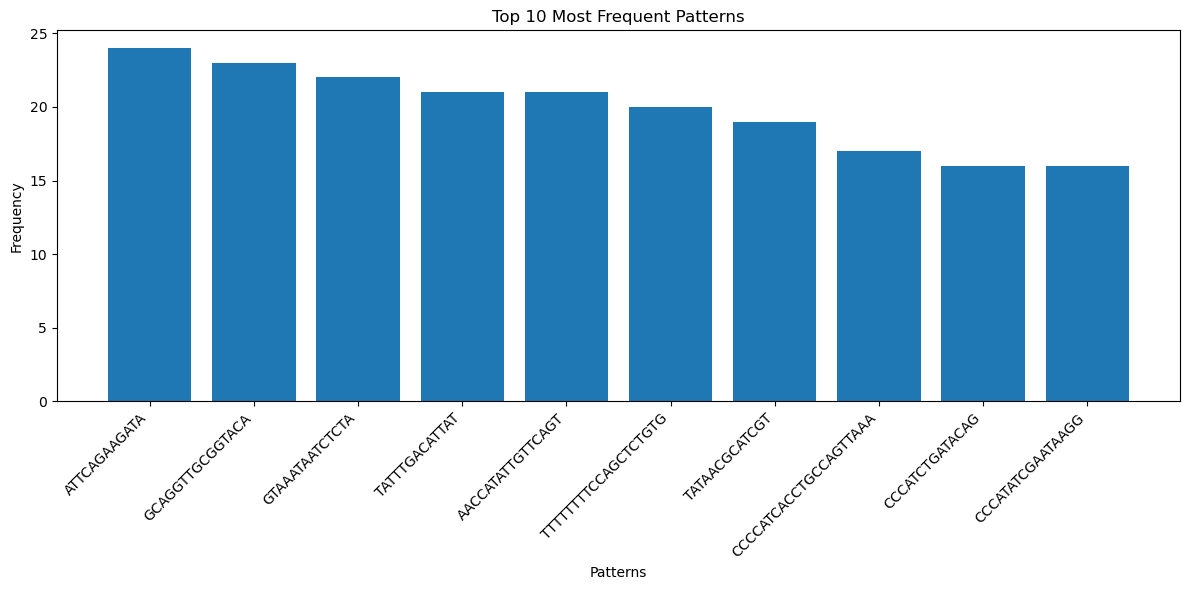

In [18]:
import json
import matplotlib.pyplot as plt

with open('json/recurring_patterns/filtered_recurring_patterns.json', 'r') as file:
    all_recurring_patterns = json.load(file)

pattern_freq = [(pattern, len(all_recurring_patterns[pattern])) for pattern in all_recurring_patterns]

sorted_patterns = sorted(pattern_freq, key=lambda x: x[1], reverse=True)

top_10_patterns = []

for pattern, freq in sorted_patterns:
    is_subpattern_or_superpattern = False
    for top_pattern, _ in top_10_patterns:
        if pattern in top_pattern or top_pattern[1:-1] in pattern:
            is_subpattern_or_superpattern = True
            break
    
    if not is_subpattern_or_superpattern:
        top_10_patterns.append((pattern, freq))
    
    if len(top_10_patterns) == 10:
        break

patterns = [pattern for pattern, _ in top_10_patterns]
frequencies = [freq for _, freq in top_10_patterns]

plt.figure(figsize=(12, 6))
plt.bar(patterns, frequencies)
plt.xlabel('Patterns')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Patterns')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

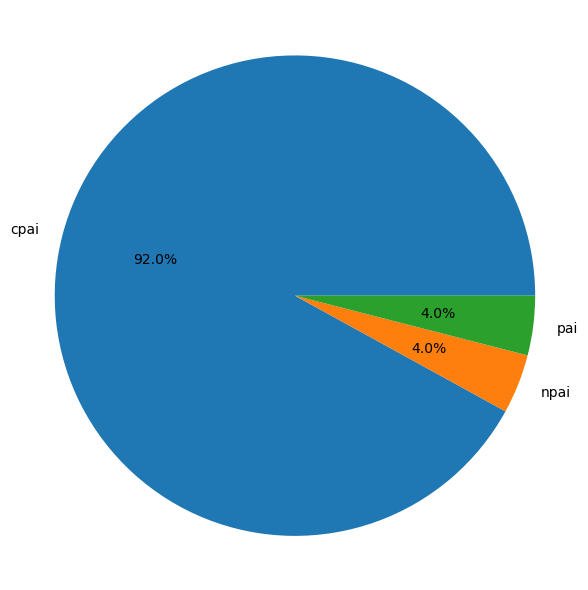

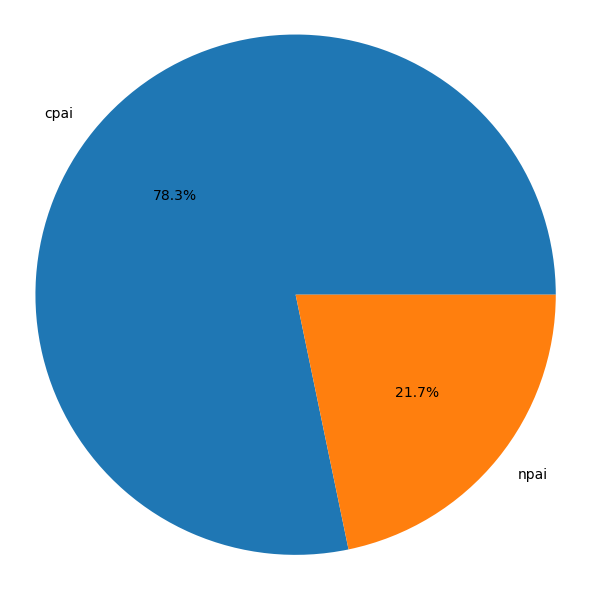

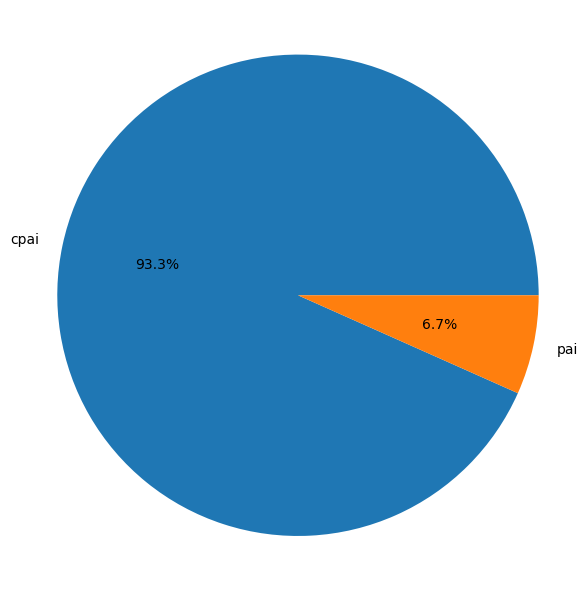

In [23]:
import json
import matplotlib.pyplot as plt

with open('json/recurring_patterns/filtered_recurring_patterns.json', 'r') as file:
    all_recurring_patterns = json.load(file)

pattern_freq = [(pattern, sum(sum(island_counts.values()) for island_counts in genome_counts.values())) for pattern, genome_counts in all_recurring_patterns.items()]

sorted_patterns = sorted(pattern_freq, key=lambda x: x[1], reverse=True)

top_3_patterns = []

for pattern, freq in sorted_patterns:
    is_subpattern_or_superpattern = False
    for top_pattern, _ in top_3_patterns:
        if pattern in top_pattern or top_pattern[1:-1] in pattern:
            is_subpattern_or_superpattern = True
            break
    
    if not is_subpattern_or_superpattern:
        top_3_patterns.append((pattern, freq))
    
    if len(top_3_patterns) == 3:
        break

def autopct_format(pct):
    return f'{pct:.1f}%' if pct > 0 else ''

for i, (pattern, _) in enumerate(top_3_patterns, start=1):
    cpai_count = sum(occurrences for genome_counts in all_recurring_patterns[pattern].values() for island, occurrences in genome_counts.items() if 'cpai' in island)
    npai_count = sum(occurrences for genome_counts in all_recurring_patterns[pattern].values() for island, occurrences in genome_counts.items() if 'npai' in island)
    pai_count = sum(occurrences for genome_counts in all_recurring_patterns[pattern].values() for island, occurrences in genome_counts.items() if 'pai' in island and 'cpai' not in island and 'npai' not in island)

    labels = ['cpai', 'npai', 'pai']
    sizes = [cpai_count, npai_count, pai_count]

    labels = [label for label, size in zip(labels, sizes) if size > 0]
    sizes = [size for size in sizes if size > 0]

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct=autopct_format)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

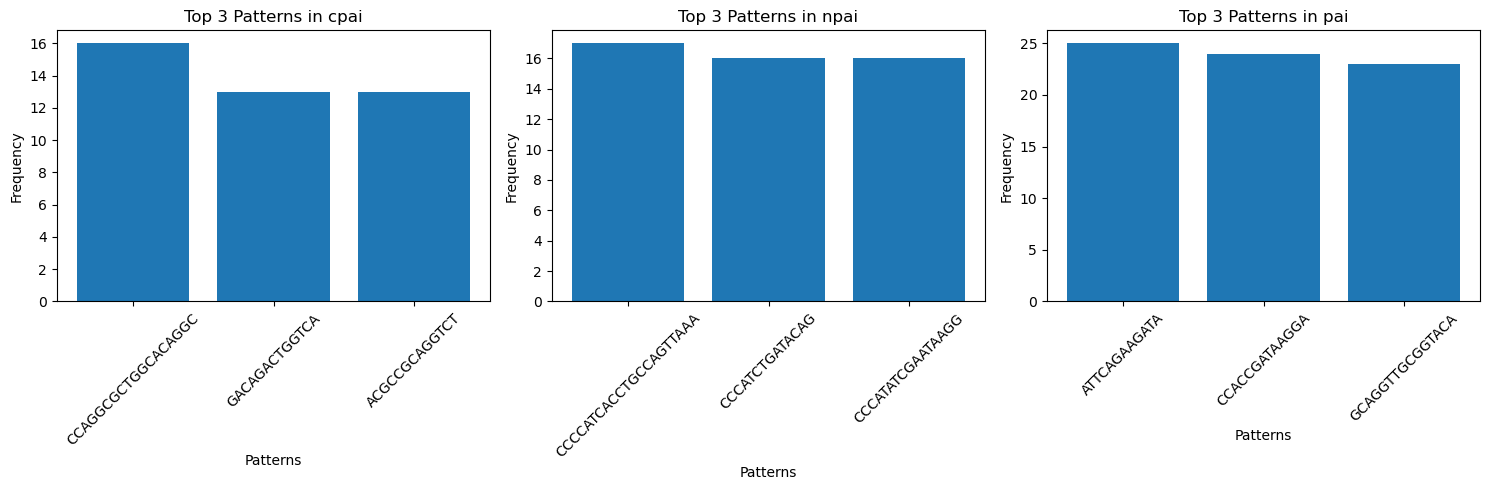

In [28]:
import json
import matplotlib.pyplot as plt

with open('json/recurring_patterns/filtered_recurring_patterns.json', 'r') as file:
    all_recurring_patterns = json.load(file)

def is_pattern_specific_to_class(pattern, class_name):
    for genome_counts in all_recurring_patterns[pattern].values():
        for island in genome_counts.keys():
            if class_name not in island:
                return False
    return True

def get_pattern_frequency(pattern, class_name):
    frequency = sum(len(genome_counts) for genome_counts in all_recurring_patterns[pattern].values() if is_pattern_specific_to_class(pattern, class_name))
    return frequency

def get_top_patterns_per_class(class_name):
    pattern_freq = [(pattern, get_pattern_frequency(pattern, class_name)) for pattern in all_recurring_patterns if is_pattern_specific_to_class(pattern, class_name)]
    
    sorted_patterns = sorted(pattern_freq, key=lambda x: x[1], reverse=True)
    
    top_3_patterns = []
    
    for pattern, freq in sorted_patterns:
        is_subpattern_or_superpattern = False
        for top_pattern, _ in top_3_patterns:
            if pattern in top_pattern or top_pattern[1:-1] in pattern:
                is_subpattern_or_superpattern = True
                break
        
        if not is_subpattern_or_superpattern:
            top_3_patterns.append((pattern, freq))
        
        if len(top_3_patterns) == 3:
            break
    
    return top_3_patterns

classes = ['cpai', 'npai', 'pai']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, class_name in enumerate(classes):
    top_3_patterns = get_top_patterns_per_class(class_name)
    
    patterns = [pattern for pattern, _ in top_3_patterns]
    frequencies = [freq for _, freq in top_3_patterns]
    
    axs[i].bar(patterns, frequencies)
    axs[i].set_title(f'Top 3 Patterns in {class_name}')
    axs[i].set_xlabel('Patterns')
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()